In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
from statsmodels.stats.multitest import multipletests
from collections import namedtuple
from scipy import special

def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = special.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [2]:
peak_area_filename = "../data/hamster_plasma_all_modes.csv"
experiment_parameters = "../data/hamster_plasma_experiment_parameters.csv"

In [3]:
data = pd.read_csv(peak_area_filename)
data

,Compound Name,Compound Class,Chromatography - ion mode,Compound Name Leg,Formula,Mass,RT,CAS ID,blank-1,blank-2,...,P H-513,P H-514,P H-515,P H-516,QC-P pool-1,QC-P pool-2,QC-P pool-3,QC-P pool-4,QC-P pool-5,QC-P pool-6
0,1_(Z)-3-Hydroxyoctadec-7-enoic acid,covid_id_updated,pHILICneg,pHILICneg_1_(Z)-3-Hydroxyoctadec-7-enoic acid,C18H34O3,298.250795,0.82,NaN,5227,17457,...,772207,122564,282412,579306,410157,375957,380534,342191,354302,389796
1,2_1 5 Anhydro D glucitol,covid_id_updated,pHILICneg,pHILICneg_2_1 5 Anhydro D glucitol,C6H12O5,164.068474,4.56,NaN,2434,1891,...,232718,105401,132976,126072,194553,178096,166137,148775,161153,129277
2,5_14 Z Eicosenoic acid,covid_id_updated,pHILICneg,pHILICneg_5_14 Z Eicosenoic acid,C20H38O2,310.287181,0.77,NaN,2745,3279,...,595896,232450,609587,1116064,610018,571881,561207,571224,556859,570672
3,6_16 Hydroxyhexadecanoic acid,covid_id_updated,pHILICneg,pHILICneg_6_16 Hydroxyhexadecanoic acid,C16H32O3,272.235145,0.84,NaN,15266,4962,...,237691,134103,241330,272484,357661,299087,247931,232537,223569,228274
4,8_2 Aminoadipic acid,covid_id_updated,pHILICneg,pHILICneg_8_2 Aminoadipic acid,C6H11NO4,161.068808,6.62,NaN,724,1097,...,1272,1010,1698,3114,1272,275,2137,709,776,702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,SM d34:2@15.078,Sphingomyelin,HSSneg,HSSneg_SM d34:2@15.078,C39H77N2O6P,700.551925,15.00,NaN,6637,1473,...,6088485,5967489,7305753,6481785,10827467,10396119,8507003,7454636,6364081,5663845
590,SM d36:1@18.052,Sphingomyelin,HSSneg,HSSneg_SM d36:1@18.052,C41H83N2O6P,730.598876,17.97,NaN,8180,8507,...,446365,371813,541213,239936,788688,751911,666222,546870,428824,394352
591,SM d41:2@20.495,Sphingomyelin,HSSneg,HSSneg_SM d41:2@20.495,C46H91N2O6P,798.661476,20.41,NaN,36806,52204,...,364633,636986,1045934,221323,1930169,1656302,1331255,1042535,740336,620862
592,SM d42:2@20.926,Sphingomyelin,HSSneg,HSSneg_SM d42:2@20.926,C47H93N2O6P,812.677126,20.90,NaN,52974,43191,...,892068,1018512,2354259,512908,3953575,3631322,2515256,2265856,1819983,1433997


In [4]:
sample_info = pd.read_csv(experiment_parameters,index_col=0)
sample_info

,Grouping,Group,Day post infection,Group-day
Sample Name,,,,
P H-433,Plasma,Influenza,4,Influenza_d4
P H-457,Plasma,Influenza,4,Influenza_d4
P H-458,Plasma,Influenza,4,Influenza_d4
P H-459,Plasma,SARS-CoV-2,14,SARS-CoV-2_d14
P H-460,Plasma,Influenza,4,Influenza_d4
P H-461,Plasma,Influenza,6,Influenza_d6
P H-462,Plasma,Influenza,6,Influenza_d6
P H-463,Plasma,SARS-CoV-2,6,SARS-CoV-2_d6
P H-464,Plasma,Mock,4,Mock_d4


56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

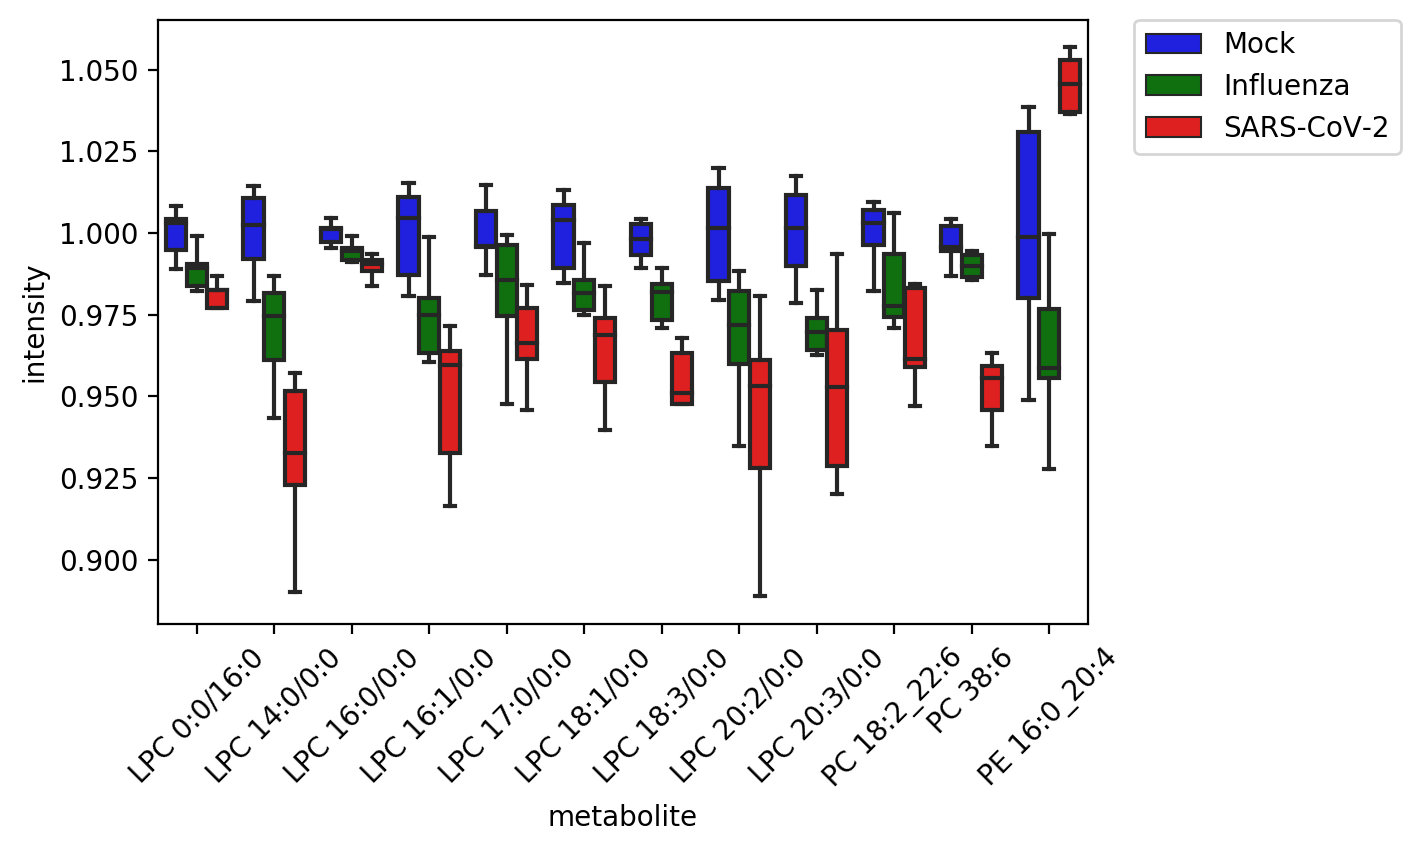

In [5]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [4]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [marker(sample_info.at[x,"Group"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x] == 2]
mock_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x] == 0]

alpha = 0.05
pvals = []
plot_dfs = []

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]]
    #stat,pval = stats.f_oneway(sub[influenza_samples],sub[covid_samples],sub[mock_samples])
    stat,pval = welch_anova_np(sub[influenza_samples],sub[covid_samples],sub[mock_samples])

    pvals.append(pval)
#     if pval < alpha/len(mol_names):
#         sig_mets.append(x)
    plot_df = {}
    ind = 0
    for val in sub[influenza_samples]:
        plot_df[ind] = {"metabolite":var_names[x],"intensity":val,"Group":"Influenza"}
        ind += 1
    for val in sub[covid_samples]:
        plot_df[ind] = {"metabolite":var_names[x],"intensity":val,"Group":"SARS-CoV-2"}
        ind += 1
    for val in sub[mock_samples]:
        plot_df[ind] = {"metabolite":var_names[x],"intensity":val,"Group":"Mock"}
        ind += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
    baseline = np.mean(plot_df[plot_df["Group"] == "Mock"]["intensity"].values)
    plot_df["intensity"] = plot_df["intensity"] / baseline
    plot_dfs.append(plot_df)


reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
tot = pd.DataFrame()
for name,p,plot_df in zip(var_names,pvals_corr,plot_dfs):

    if p < alpha:
        print(name,p)

        #stat,pval = stats.ttest_ind(plot_df[plot_df["Group"] == "Influenza"]["intensity"].values,plot_df[plot_df["Group"] == "SARS-CoV-2"]["intensity"].values,equal_var=False)
        #if pval < alpha:
        if len(tot) == 0:
            tot = plot_df
        else:
            tot = pd.concat((tot,plot_df),axis=0)

ax = sb.boxplot(data=tot,x="metabolite",y="intensity",hue="Group",fliersize=0,hue_order=["Mock","Influenza","SARS-CoV-2"],palette={"Mock":"blue","Influenza":"green","SARS-CoV-2":"red"})
#sb.swarmplot(data=tot,x="metabolite",y="intensity",hue="Group",dodge=True,hue_order=["Mock","Influenza","SARS-CoV-2"],palette={"Mock":"blue","Influenza":"green","SARS-CoV-2":"red"})
plt.xticks(rotation=45)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((-3.0,1.5))


56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

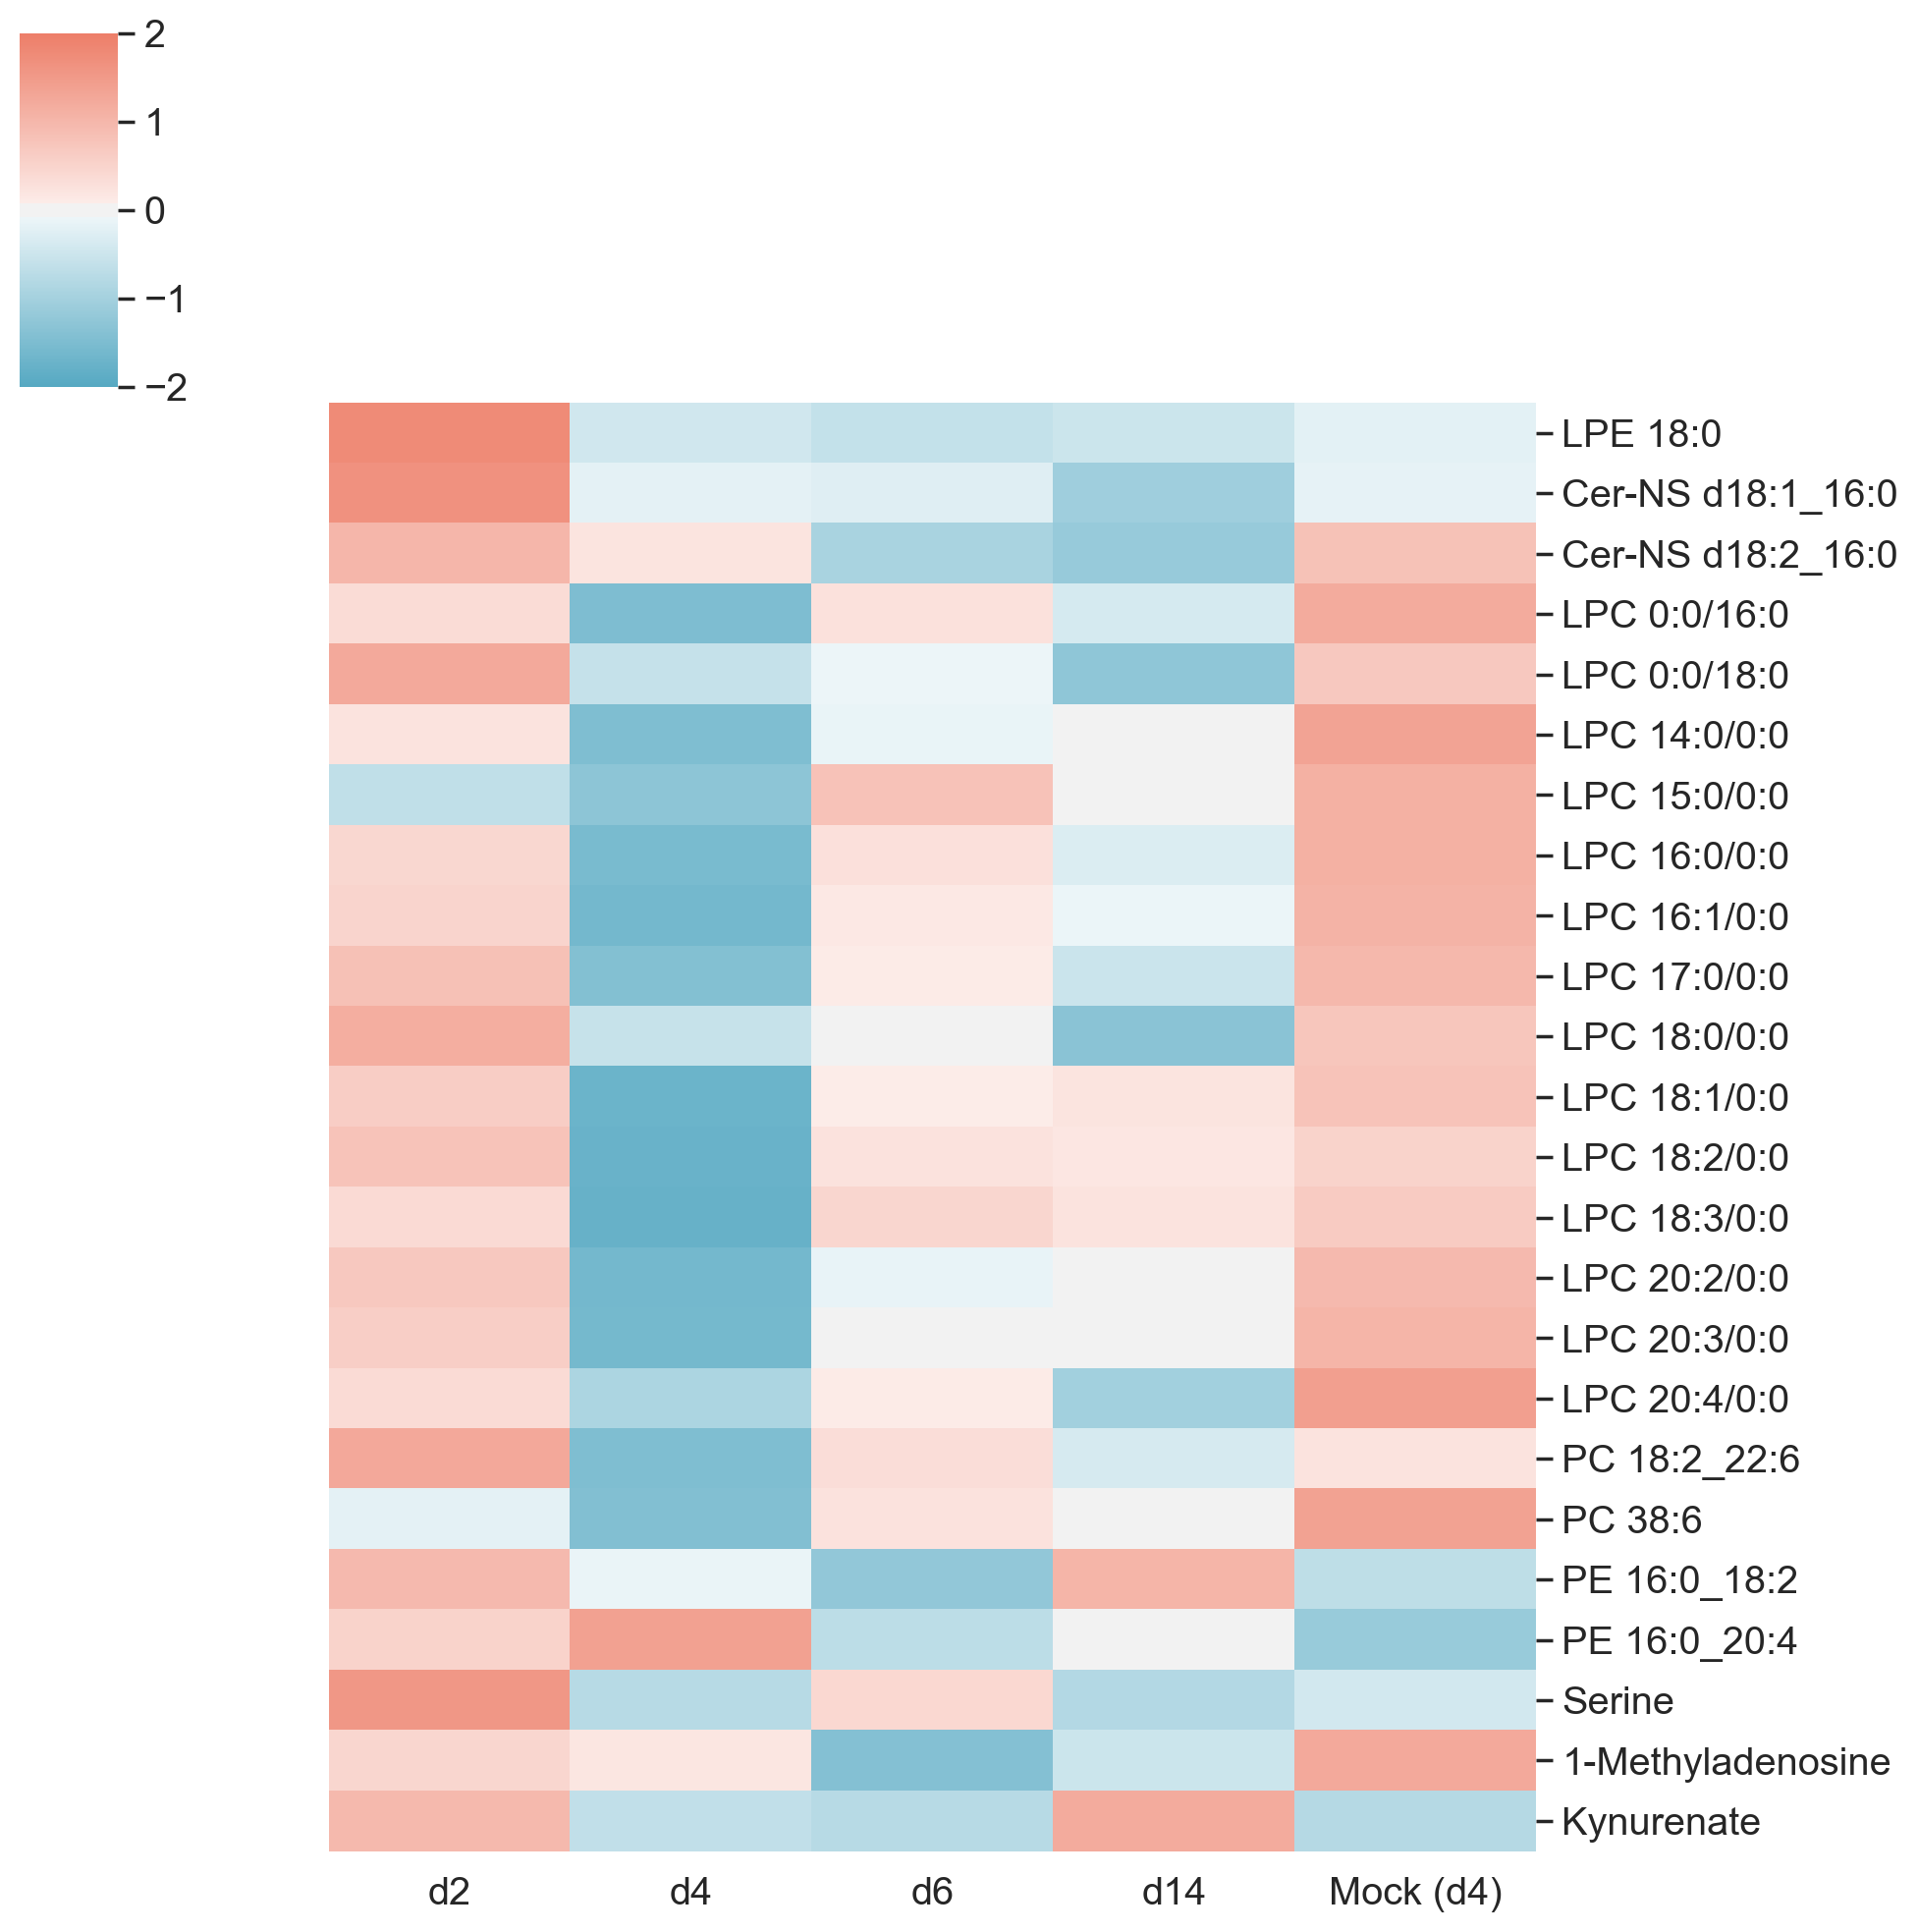

In [27]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 2]
control_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 4]

alpha = 0.05
pvals = {}
plot_df = {}
days = [2,4,6,14]

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]].values
        
    vals = [[sub[v] for v in covid_samples if sample_kind_mapping[v][1] == d] for d in days]
    
    #stat,pval = welch_anova_np(*vals)

    stat,pval = stats.ttest_ind(*vals[:2],equal_var=False)

    
    pvals[var_names[x]] = pval
    
    plot_df[var_names[x]] = {"d"+str(days[d]):np.mean(vals[d]) for d in range(len(days))}
    
    plot_df[var_names[x]]["Mock (d4)"] = np.mean(sub[control_samples])
    


sb.set(font_scale=1.3,font="Arial")

plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
sb.clustermap(data=plot_df,col_cluster=False,row_cluster=False,z_score=0,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),vmin=-2,vmax=2)

names = list(pvals.keys())
pvals = [pvals[x] for x in names]

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")

sigs = []
for p,name in zip(pvals_corr,names):
    if p < alpha:
        print(name,p)
        sigs.append(name)


56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

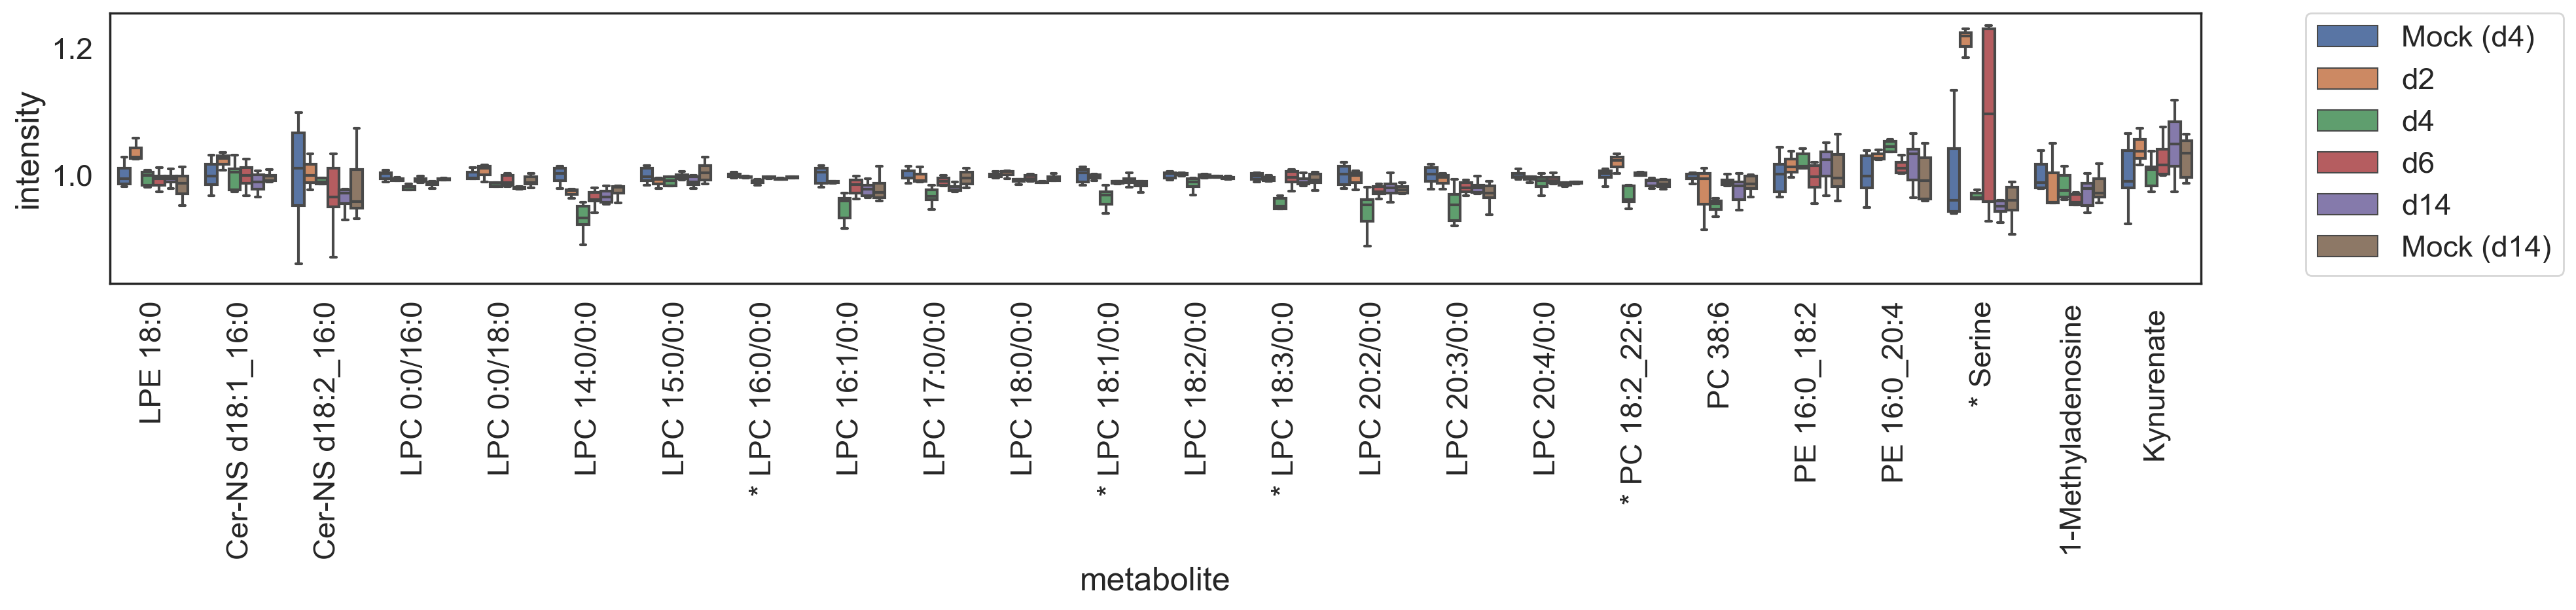

In [34]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 2]
control_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 4]
control_samples2 = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 14]


alpha = 0.05
pvals = {}
plot_df = {}
days = [2,4,6,14]
ind = 0

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]].values
        
    vals = [[sub[v] for v in covid_samples if sample_kind_mapping[v][1] == d] for d in days]
    
    #stat,pval = welch_anova_np(*vals)

    stat,pval = stats.ttest_ind(*vals[:2],equal_var=False)

        
    if var_names[x] in sigs:
        n = "* " + var_names[x]
    else:
        n = var_names[x]
    for d in range(len(days)):
        for v in vals[d]:
            plot_df[ind] = {}
            plot_df[ind]["day"] = "d"+str(days[d])
            plot_df[ind]["intensity"] = v/np.mean(sub[control_samples])
            plot_df[ind]["metabolite"] = n
            ind += 1
    for v in sub[control_samples]:
        plot_df[ind] = {"day":"Mock (d4)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    for v in sub[control_samples2]:
        plot_df[ind] = {"day":"Mock (d14)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    
plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

plt.figure(figsize=(20,5))

sb.set(font_scale=1.5,font="Arial",style="white")

sb.boxplot(data=plot_df,x="metabolite",y="intensity",hue="day",hue_order=["Mock (d4)","d2","d4","d6","d14","Mock (d14)"],fliersize=0)

plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("boxplot_hamster_long_COV.png")



56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

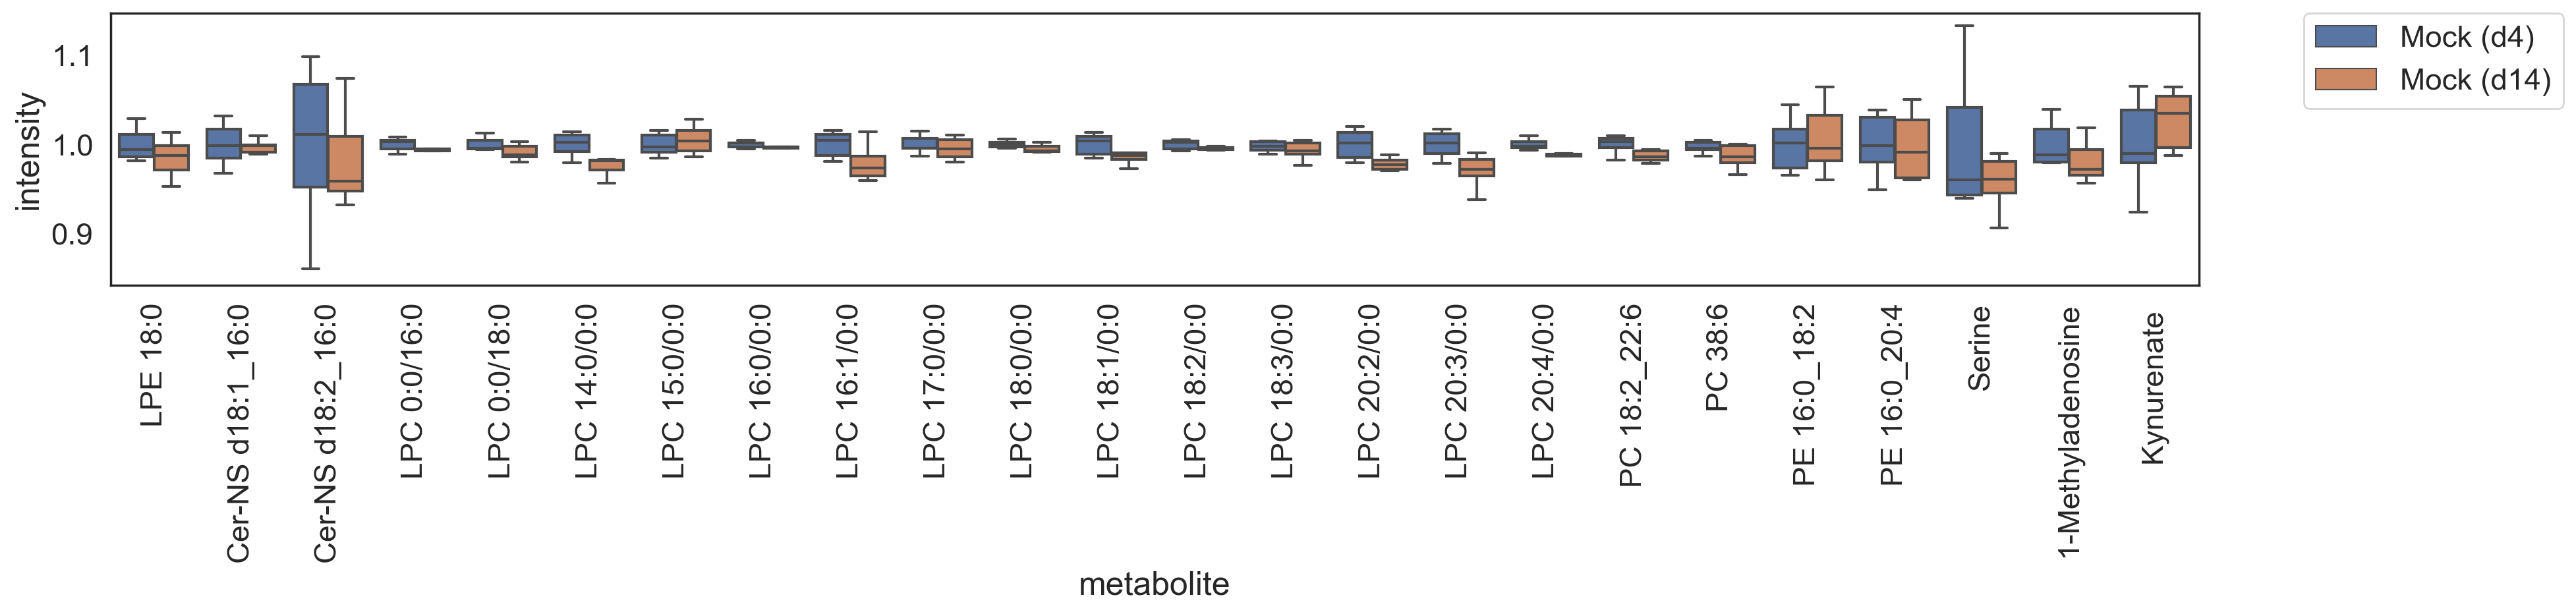

In [40]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 2]
control_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 4]
control_samples2 = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 14]


alpha = 0.05
pvals = {}
plot_df = {}
days = [2,4,6,14]
ind = 0

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]].values
    
    vals = [sub[control_samples],sub[control_samples2]]    

    stat,pval = stats.ttest_ind(*vals[:2],equal_var=False)

    pvals[var_names[x]] = pval
        
    n = var_names[x]
    
    for v in sub[control_samples]:
        plot_df[ind] = {"day":"Mock (d4)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    for v in sub[control_samples2]:
        plot_df[ind] = {"day":"Mock (d14)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    
plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

plt.figure(figsize=(20,5))

sb.set(font_scale=1.5,font="Arial",style="white")

sb.boxplot(data=plot_df,x="metabolite",y="intensity",hue="day",hue_order=["Mock (d4)","Mock (d14)"],fliersize=0)

plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("boxplot_hamster_long_mocks.png")

names = list(pvals.keys())
pvals = [pvals[x] for x in names]

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")

for p,name in zip(pvals_corr,names):
    if p < alpha:
        print(name,p)


56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

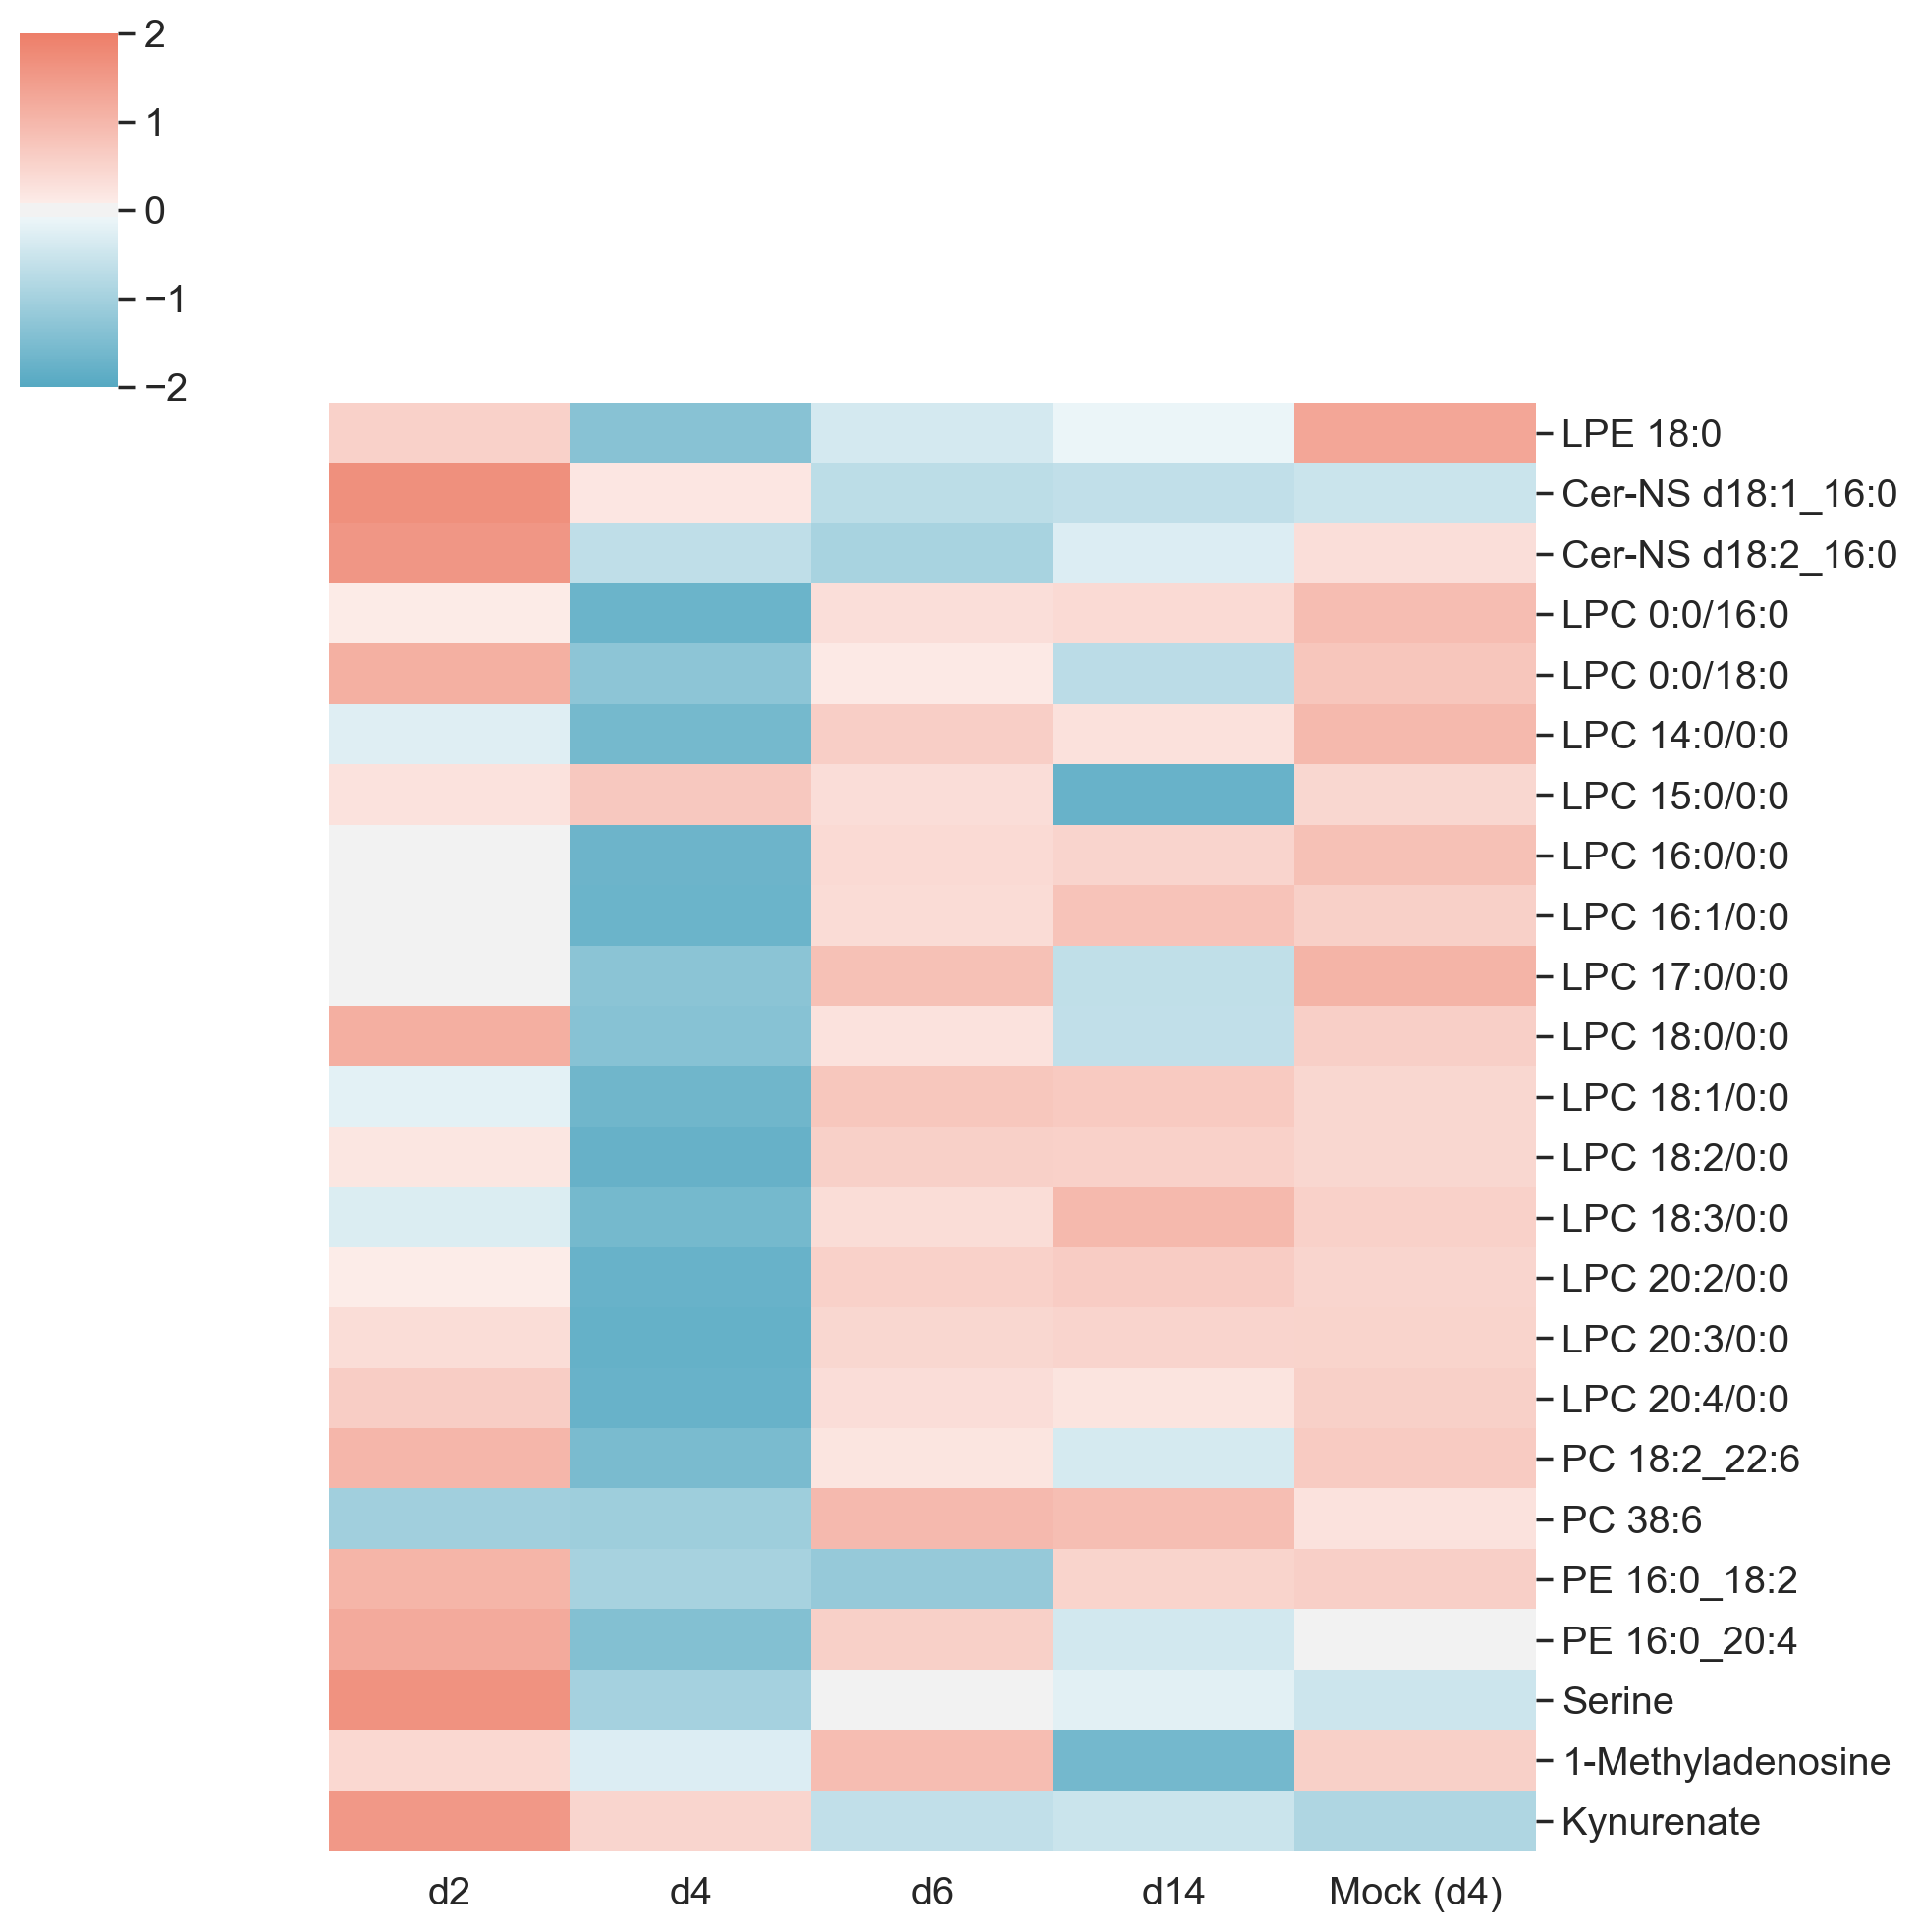

In [35]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 2]
control_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 4]

alpha = 0.05
pvals = {}
plot_df = {}
days = [2,4,6,14]

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]].values
        
    vals = [[sub[v] for v in influenza_samples if sample_kind_mapping[v][1] == d] for d in days]
    
    #stat,pval = welch_anova_np(*vals)
    
    stat,pval = stats.ttest_ind(*vals[:2],equal_var=False)


    pvals[var_names[x]] = pval
    
    plot_df[var_names[x]] = {"d"+str(days[d]):np.mean(vals[d]) for d in range(len(days))}
    
    plot_df[var_names[x]]["Mock (d4)"] = np.mean(sub[control_samples])
    


sb.set(font_scale=1.3,font="Arial")

plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
sb.clustermap(data=plot_df,col_cluster=False,row_cluster=False,z_score=0,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),vmin=-2,vmax=2)

names = list(pvals.keys())
pvals = [pvals[x] for x in names]

reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")

sigs = []
for p,name in zip(pvals_corr,names):
    if p < alpha:
        print(name,p)
        sigs.append(name)


56 56
HSSneg_LPE 18:0@7.653 HSSneg_LPE 18:0
HSSpos_Cer_NS d18:1_16:0_17.788 HSSpos_Cer_NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67 Cer_NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715 HSSpos_LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997 HSSpos_LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387 HSSpos_LPC 14:0/0:0
HSSpos_LPC 15:0/0:0_4.164 HSSpos_LPC 15:0/0:0
HSSpos_LPC 16:0/0:0_5.147 HSSpos_LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734 HSSpos_LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28 HSSpos_LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547 HSSpos_LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589 HSSpos_LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195 HSSpos_LPC 18:2/0:0
HSSpos_LPC 18:3/0:0_3.277 HSSpos_LPC 18:3/0:0
HSSpos_LPC 20:2/0:0_6.105 HSSpos_LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813 HSSpos_LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03 HSSpos_LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427 HSSpos_PC 18:2_22:6
missing HSSpos_PC 20:4_20:4_15.512
HSSpos_PC 38:6_15.829 HSSpos_PC 38:6
HSSpos_PE 16:0_18:2_16.83 PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641 PE 16:0_20:4
pHILICneg_

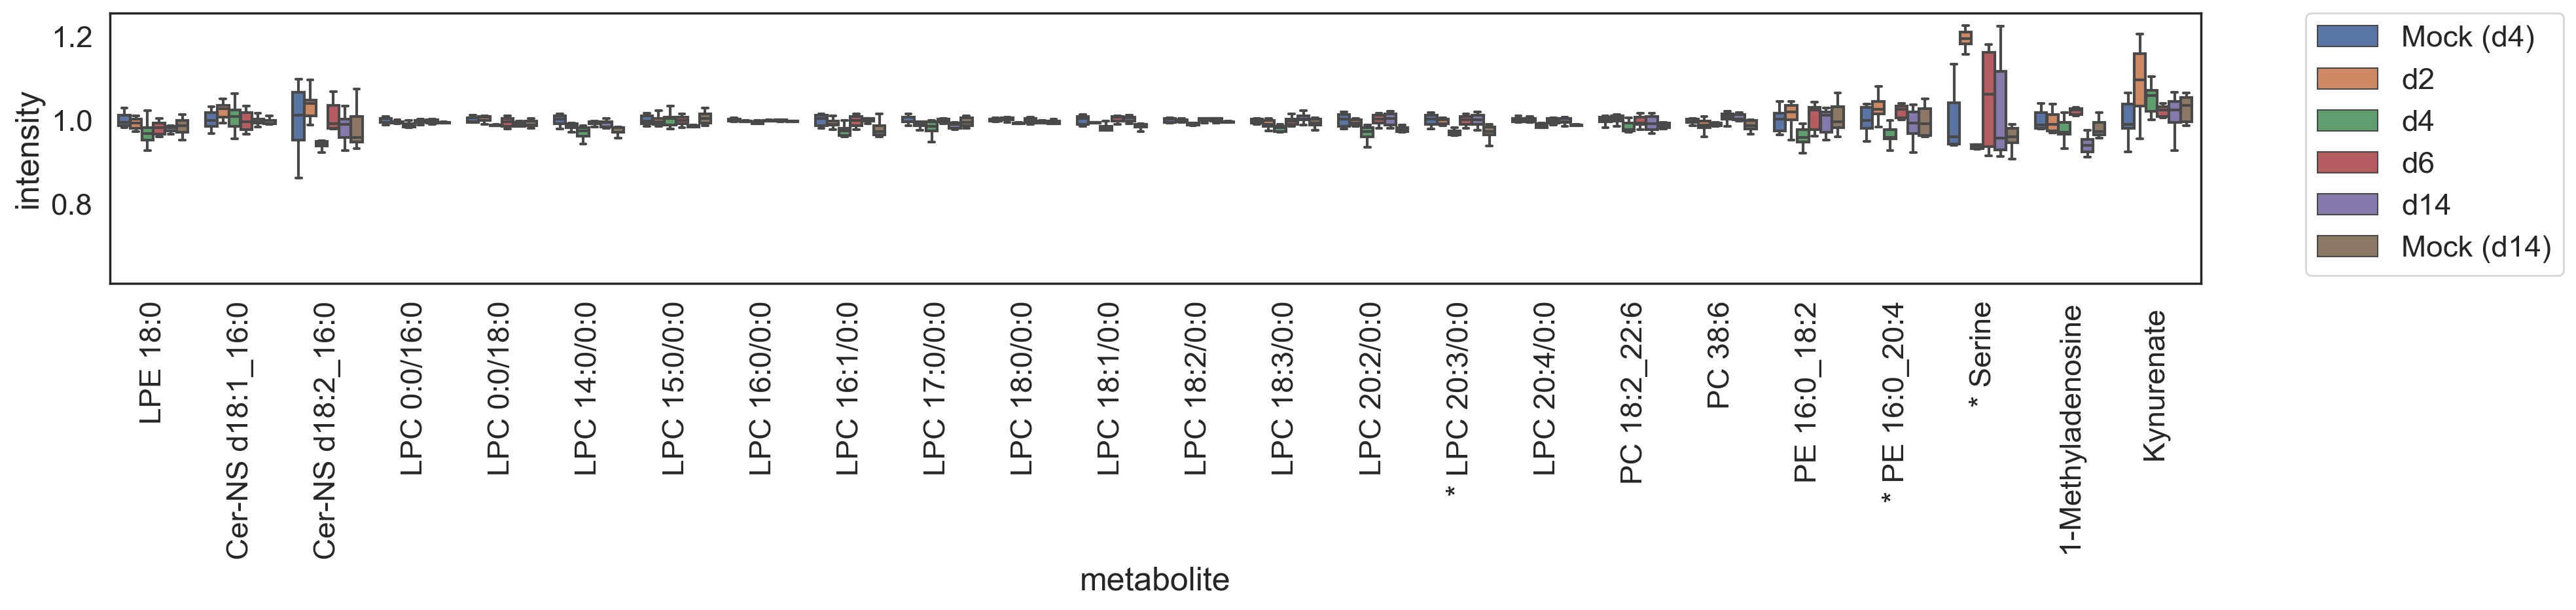

In [36]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    name = var_imp.at[x,"plot-name"]
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(name)
            print(x,y)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                print(x,y)
                vars_of_interest.append(index)
                var_names.append(name)
                found = True
                break
            index += 1
    if not found:
        print("missing",x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2","Influenza","Mock"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

def marker(ty):
    if ty == "Influenza":
        return 1
    elif ty == "SARS-CoV-2":
        return 2
    else:
        return 0
sample_kind_mapping = [(marker(sample_info.at[x,"Group"]),sample_info.at[x,"Day post infection"]) for x in data_matrix.index.values]
influenza_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 1]
covid_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 2]
control_samples = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 4]
control_samples2 = [x for x in range(len(sample_kind_mapping)) if sample_kind_mapping[x][0] == 0 and sample_kind_mapping[x][1] == 14]


alpha = 0.05
pvals = {}
plot_df = {}
days = [2,4,6,14]
ind = 0

for x in range(len(var_names)):
    sub = data_matrix[var_names[x]].values
        
    vals = [[sub[v] for v in influenza_samples if sample_kind_mapping[v][1] == d] for d in days]
    
    #stat,pval = welch_anova_np(*vals)

    stat,pval = stats.ttest_ind(*vals[:2],equal_var=False)

        
    if var_names[x] in sigs:
        n = "* " + var_names[x]
    else:
        n = var_names[x]
    for d in range(len(days)):
        for v in vals[d]:
            plot_df[ind] = {}
            plot_df[ind]["day"] = "d"+str(days[d])
            plot_df[ind]["intensity"] = v/np.mean(sub[control_samples])
            plot_df[ind]["metabolite"] = n
            ind += 1
    for v in sub[control_samples]:
        plot_df[ind] = {"day":"Mock (d4)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    for v in sub[control_samples2]:
        plot_df[ind] = {"day":"Mock (d14)","intensity":v/np.mean(sub[control_samples]),"metabolite":n}
        ind += 1
    
plot_df = pd.DataFrame.from_dict(plot_df,orient="index")

plt.figure(figsize=(20,5))

sb.set(font_scale=1.5,font="Arial",style="white")

sb.boxplot(data=plot_df,x="metabolite",y="intensity",hue="day",hue_order=["Mock (d4)","d2","d4","d6","d14","Mock (d14)"],fliersize=0)

plt.xticks(rotation=90)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend( bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("boxplot_hamster_long_inf.png")



56 56
HSSpos_PC 20:4_20:4_15.512
(56, 24)
20
0
[2, 2, 2, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 14, 14, 14, 14, 14, 14]


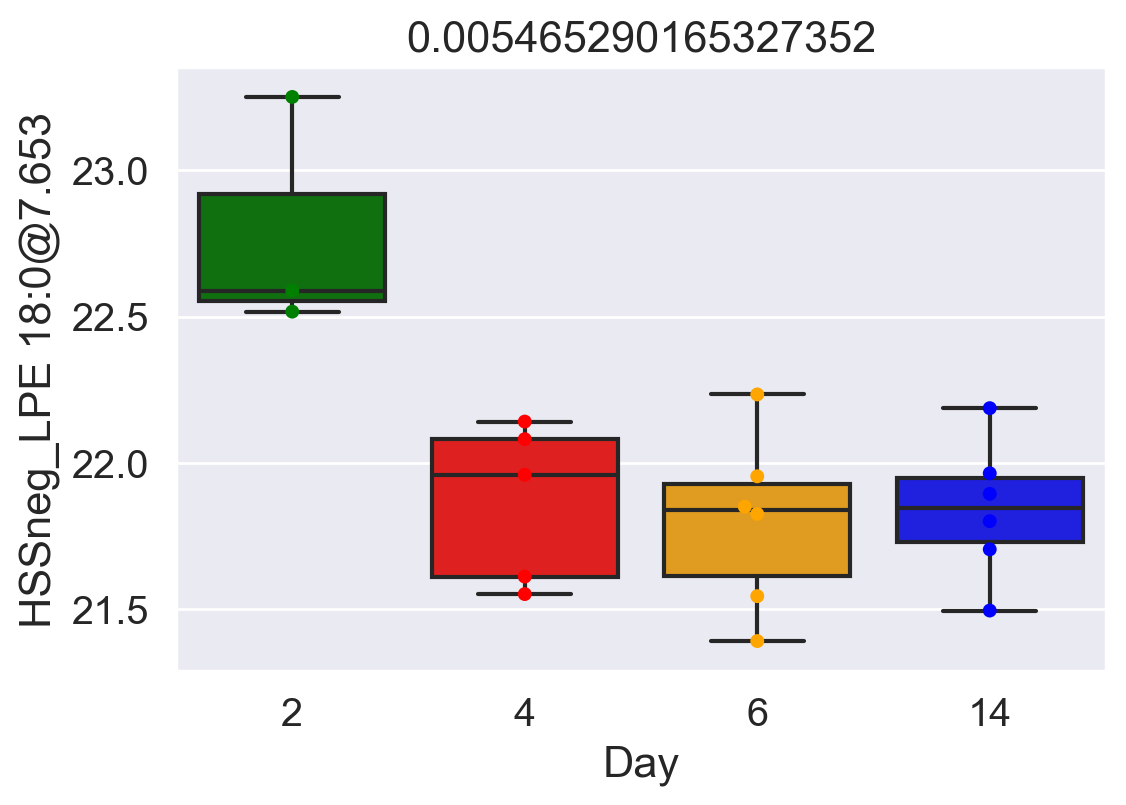

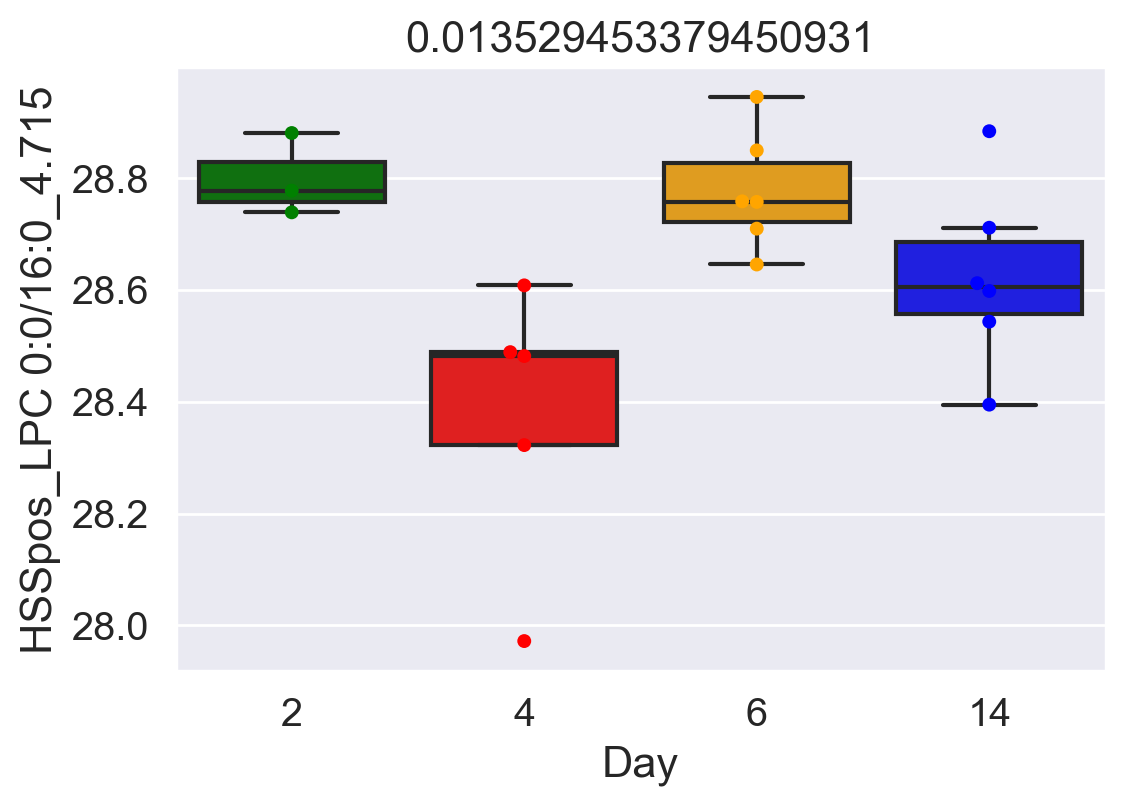

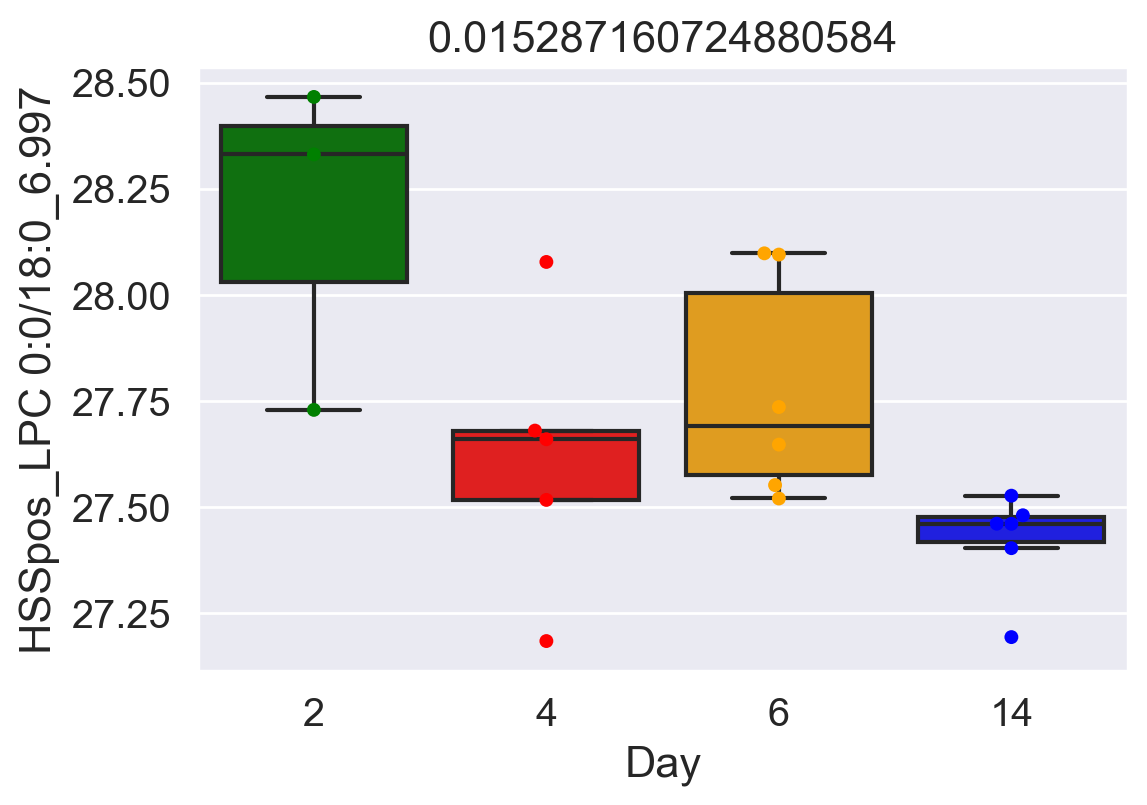

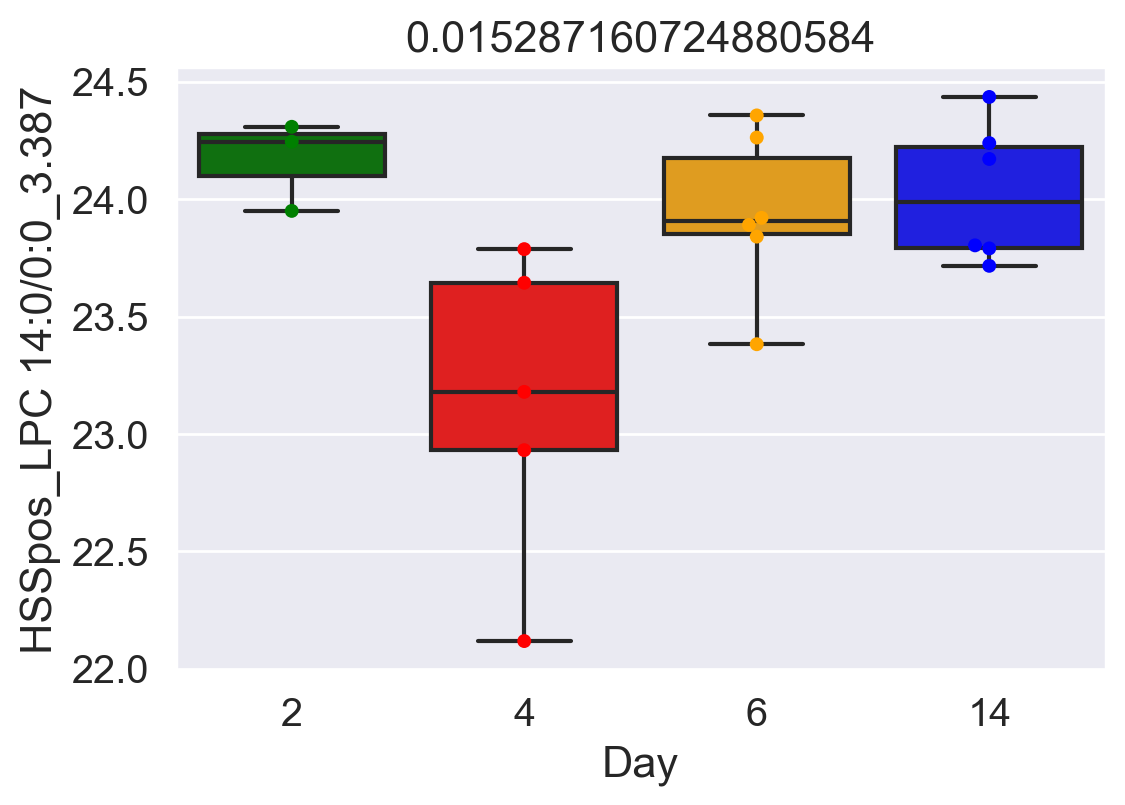

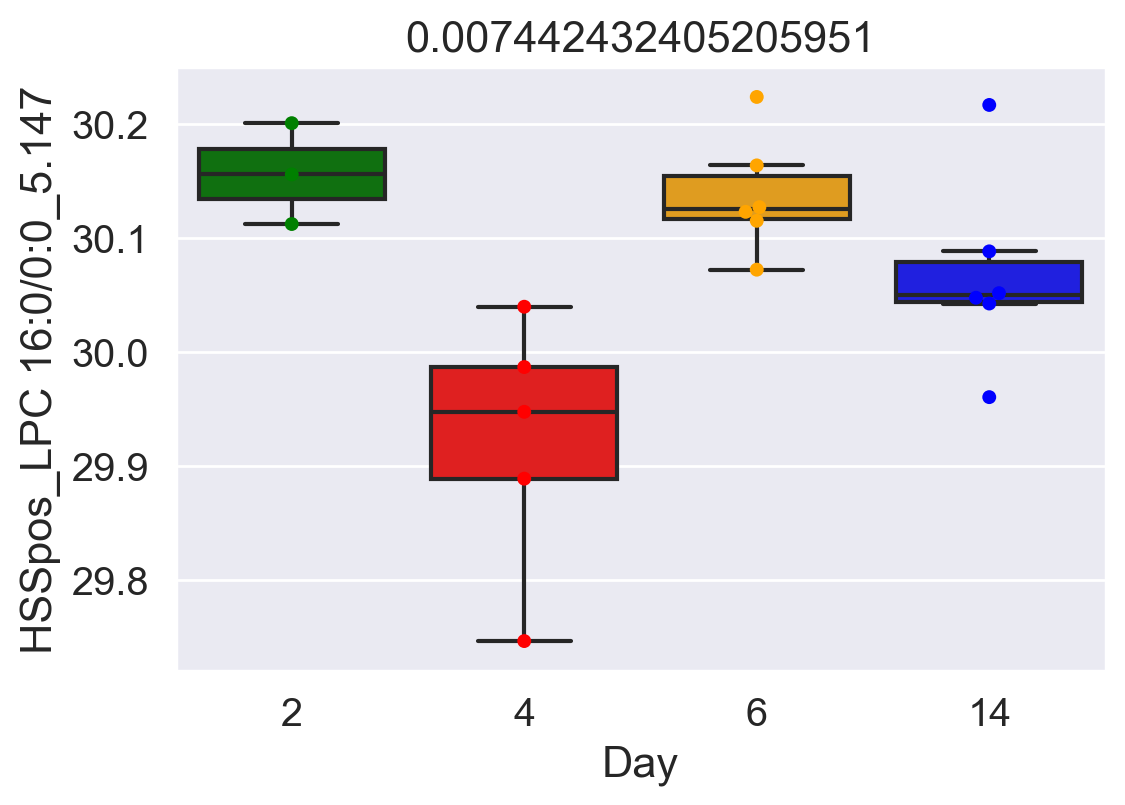

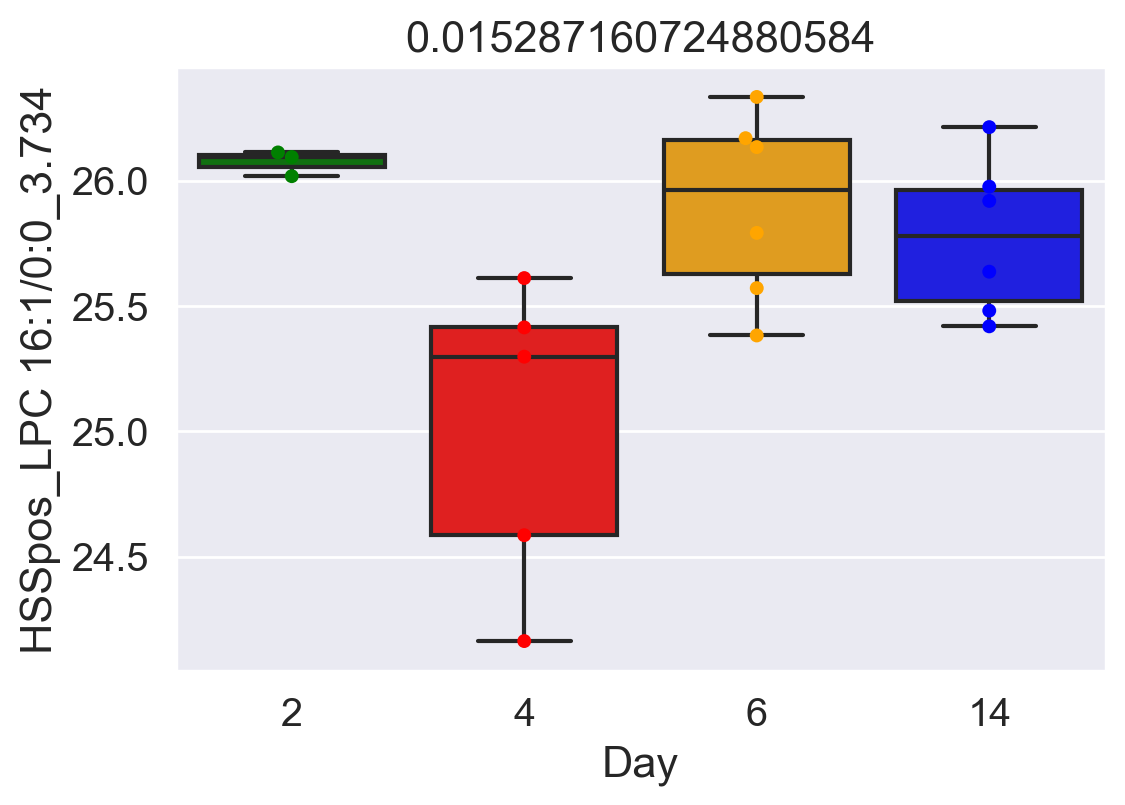

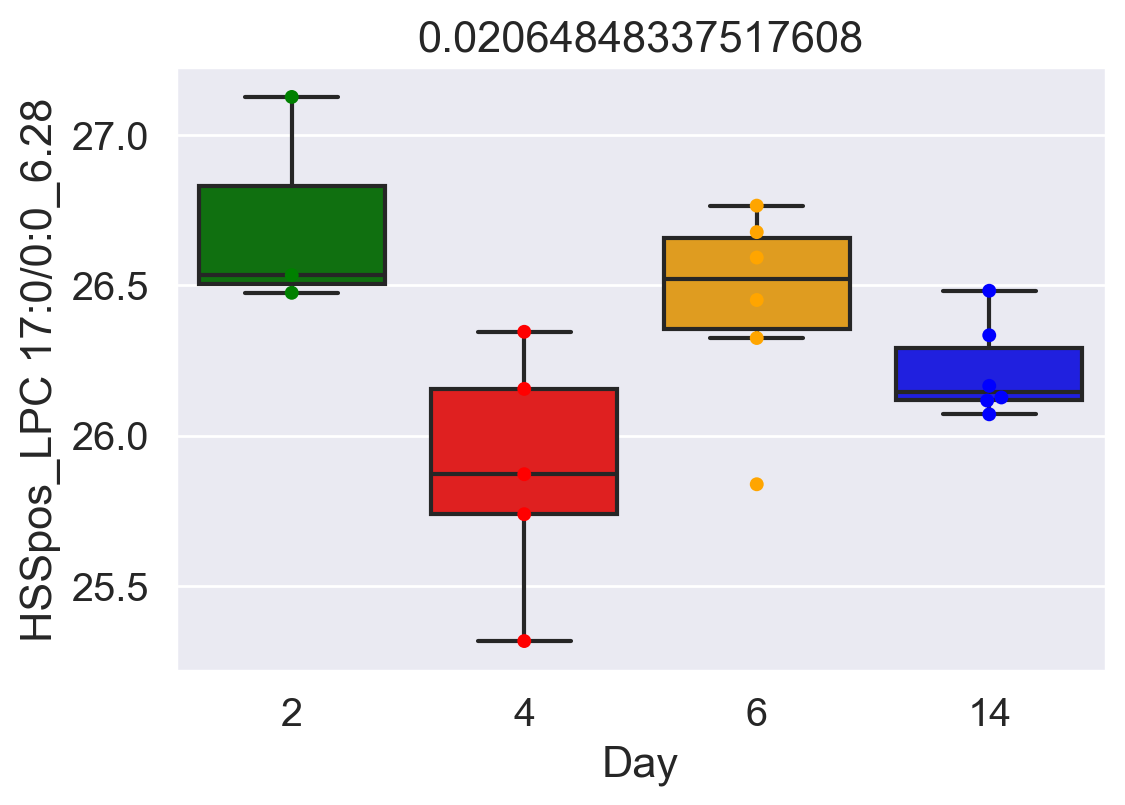

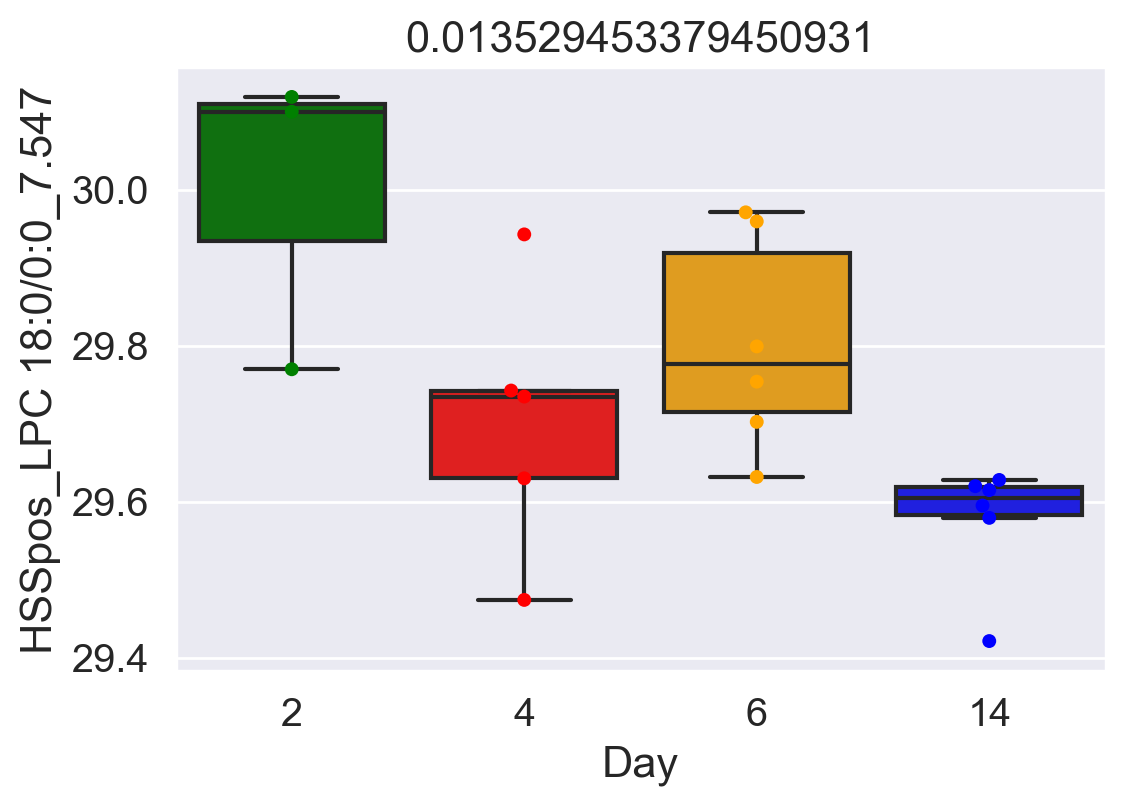

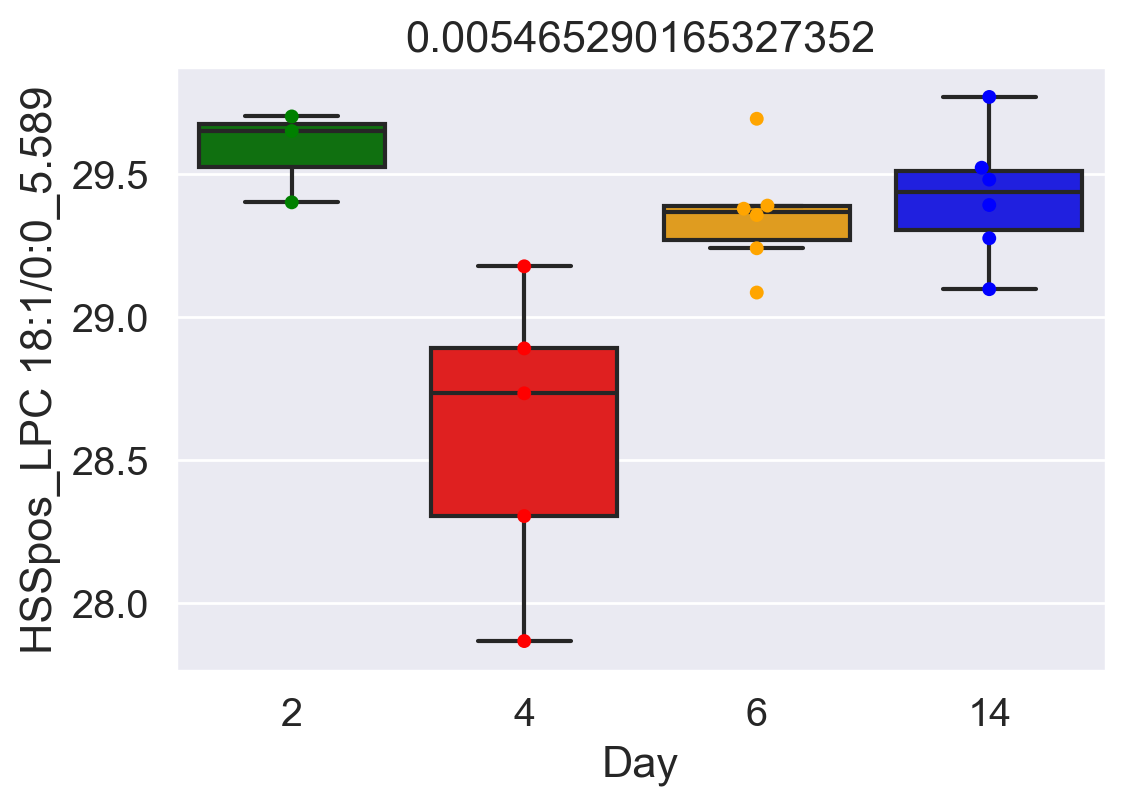

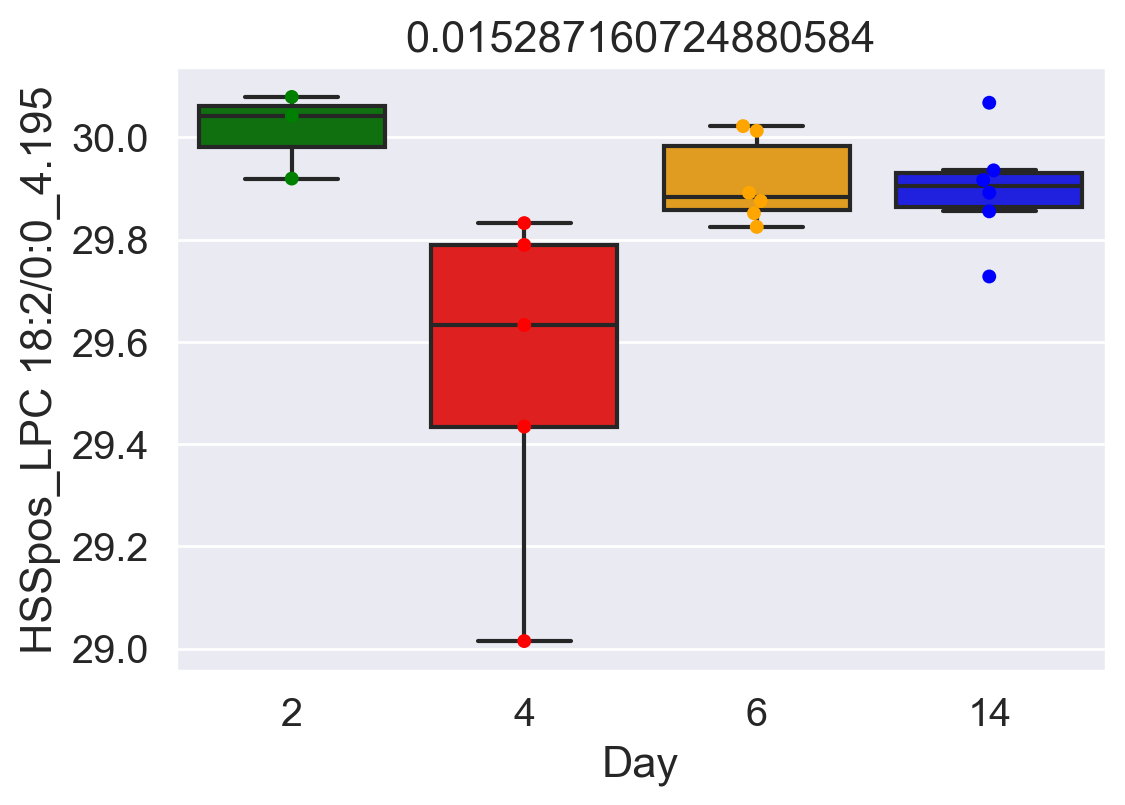

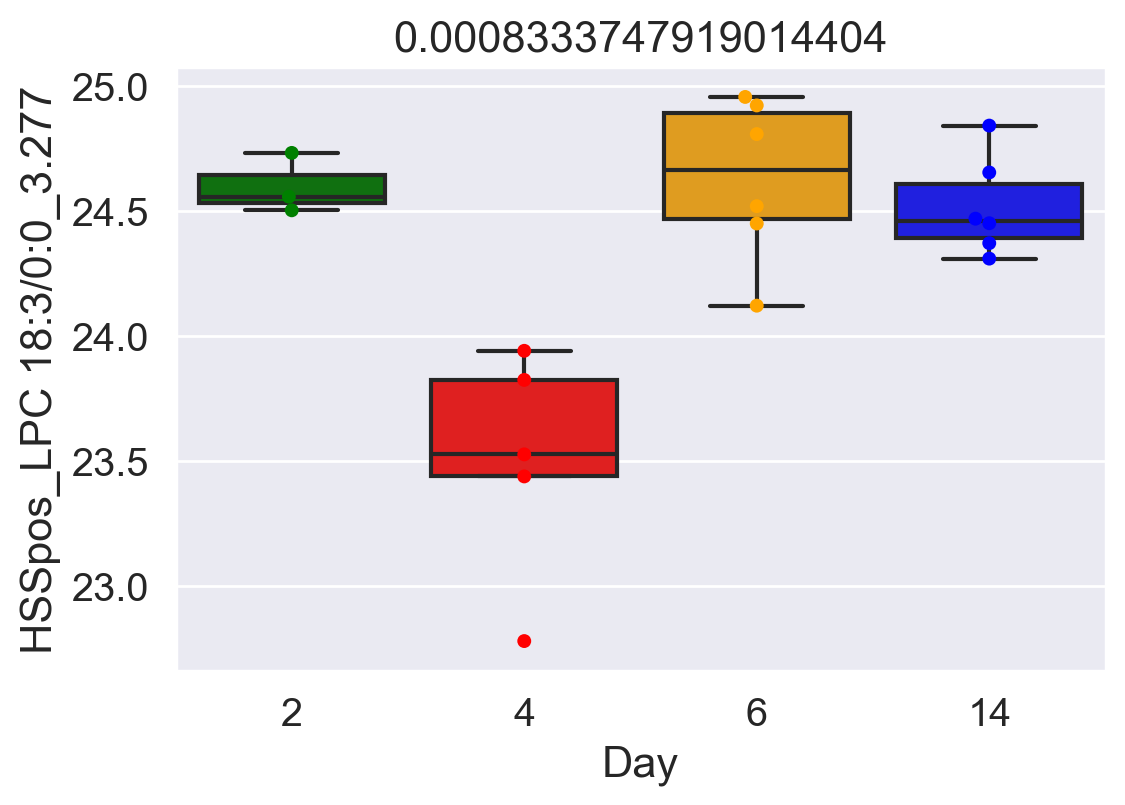

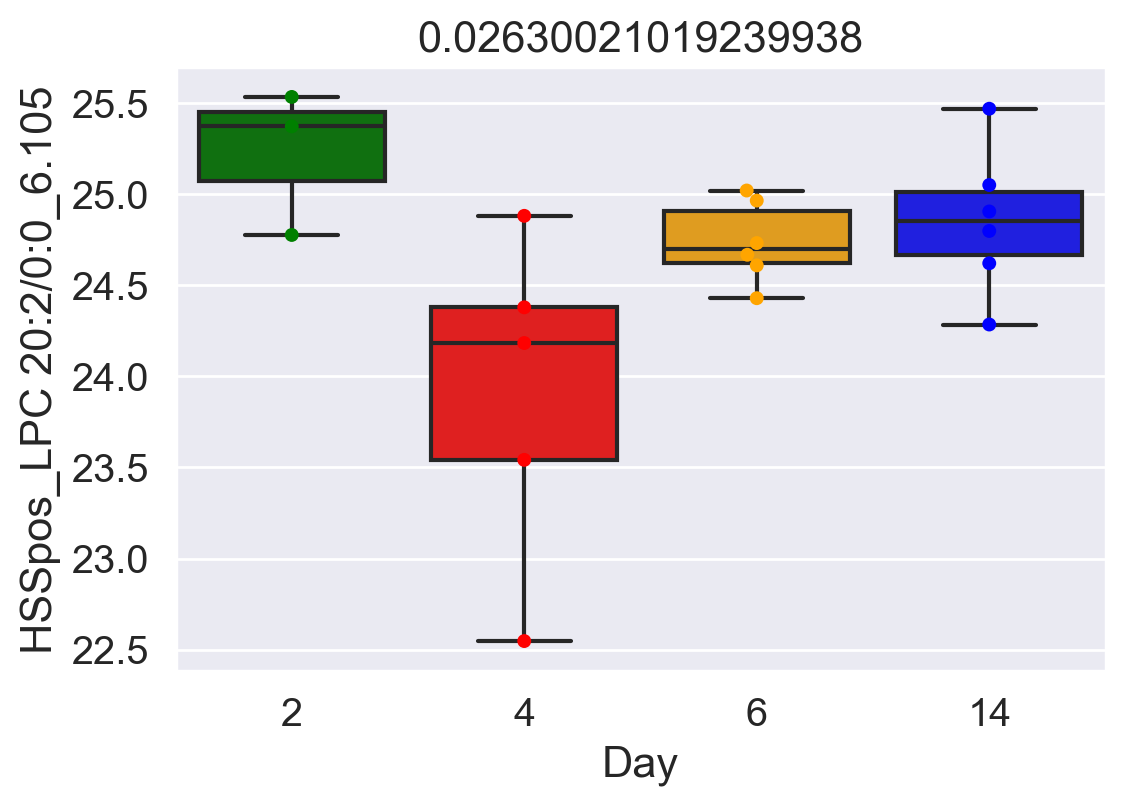

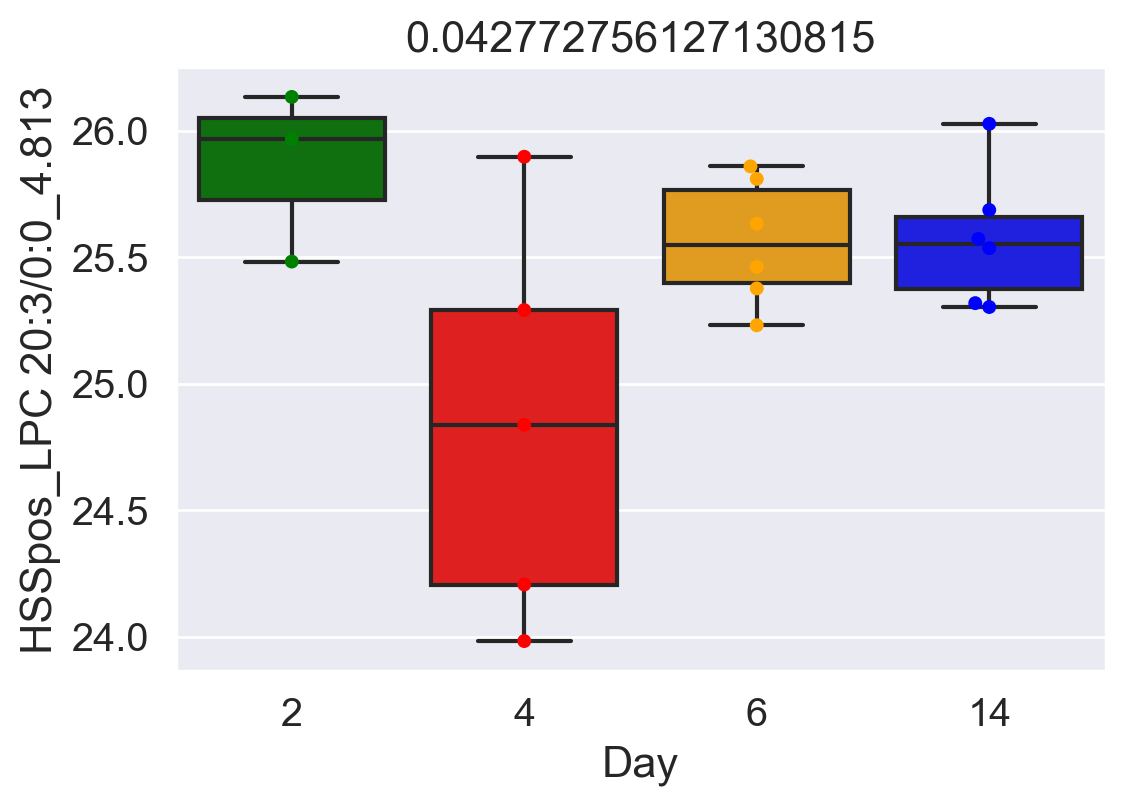

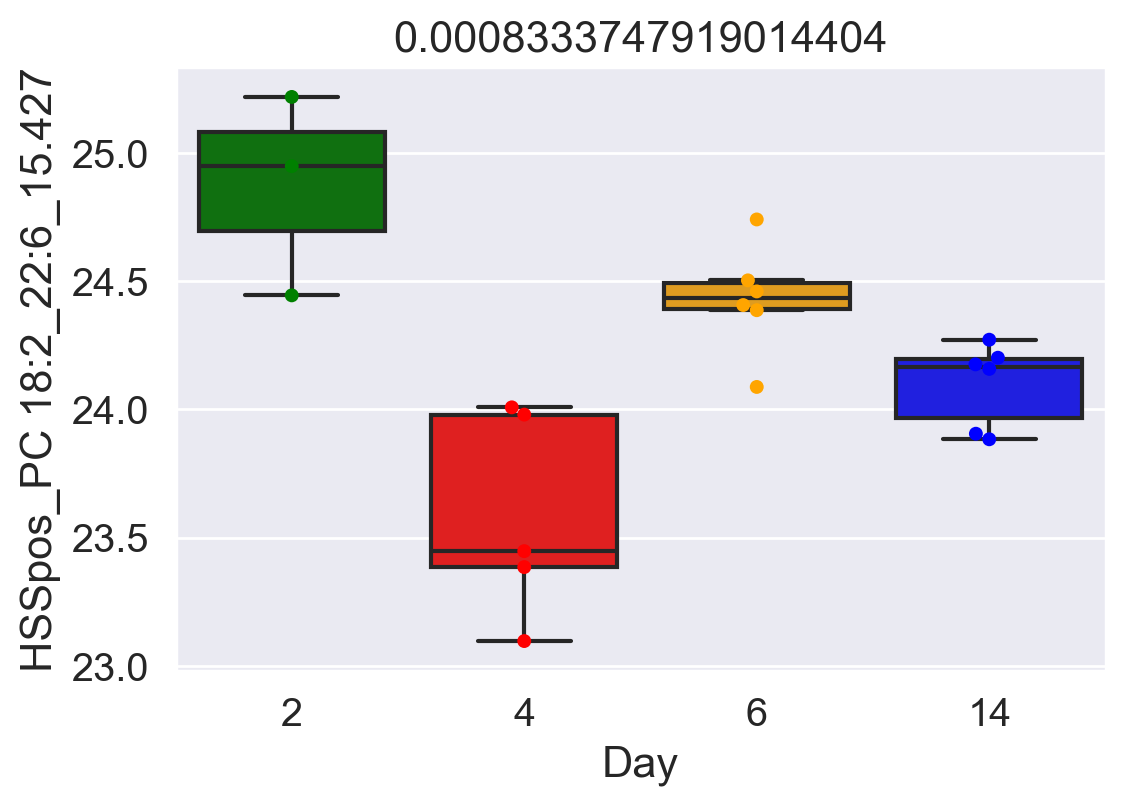

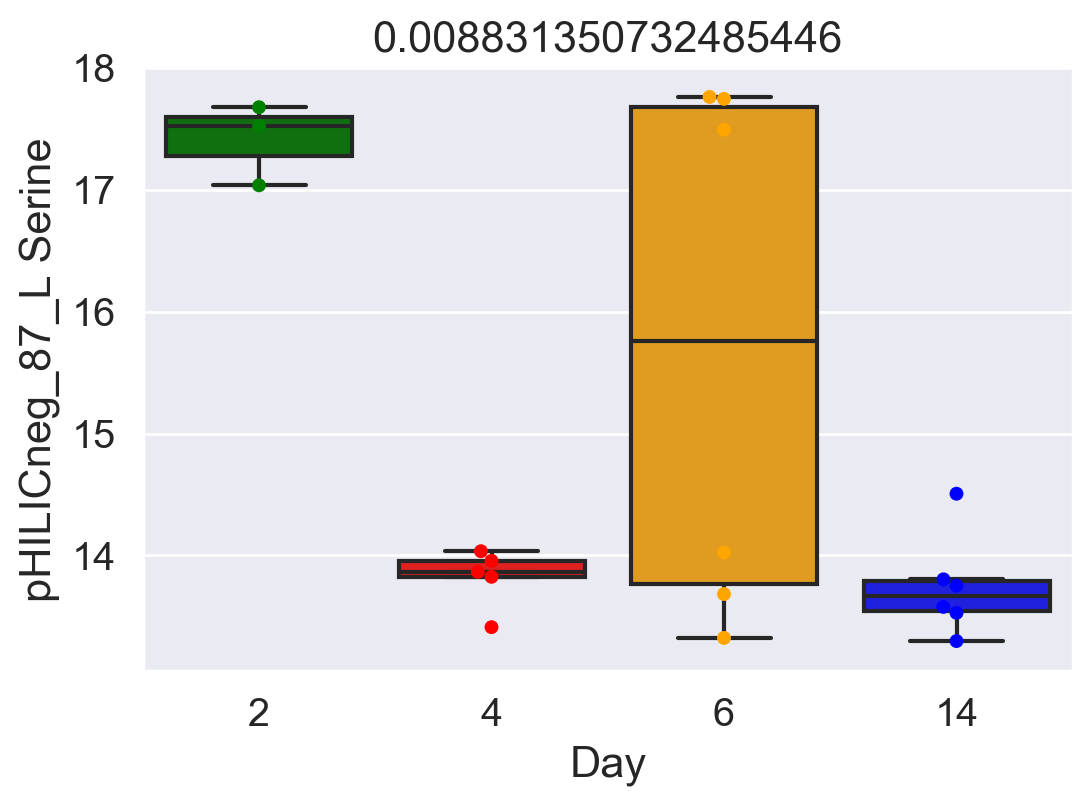

<Figure size 1200x800 with 0 Axes>

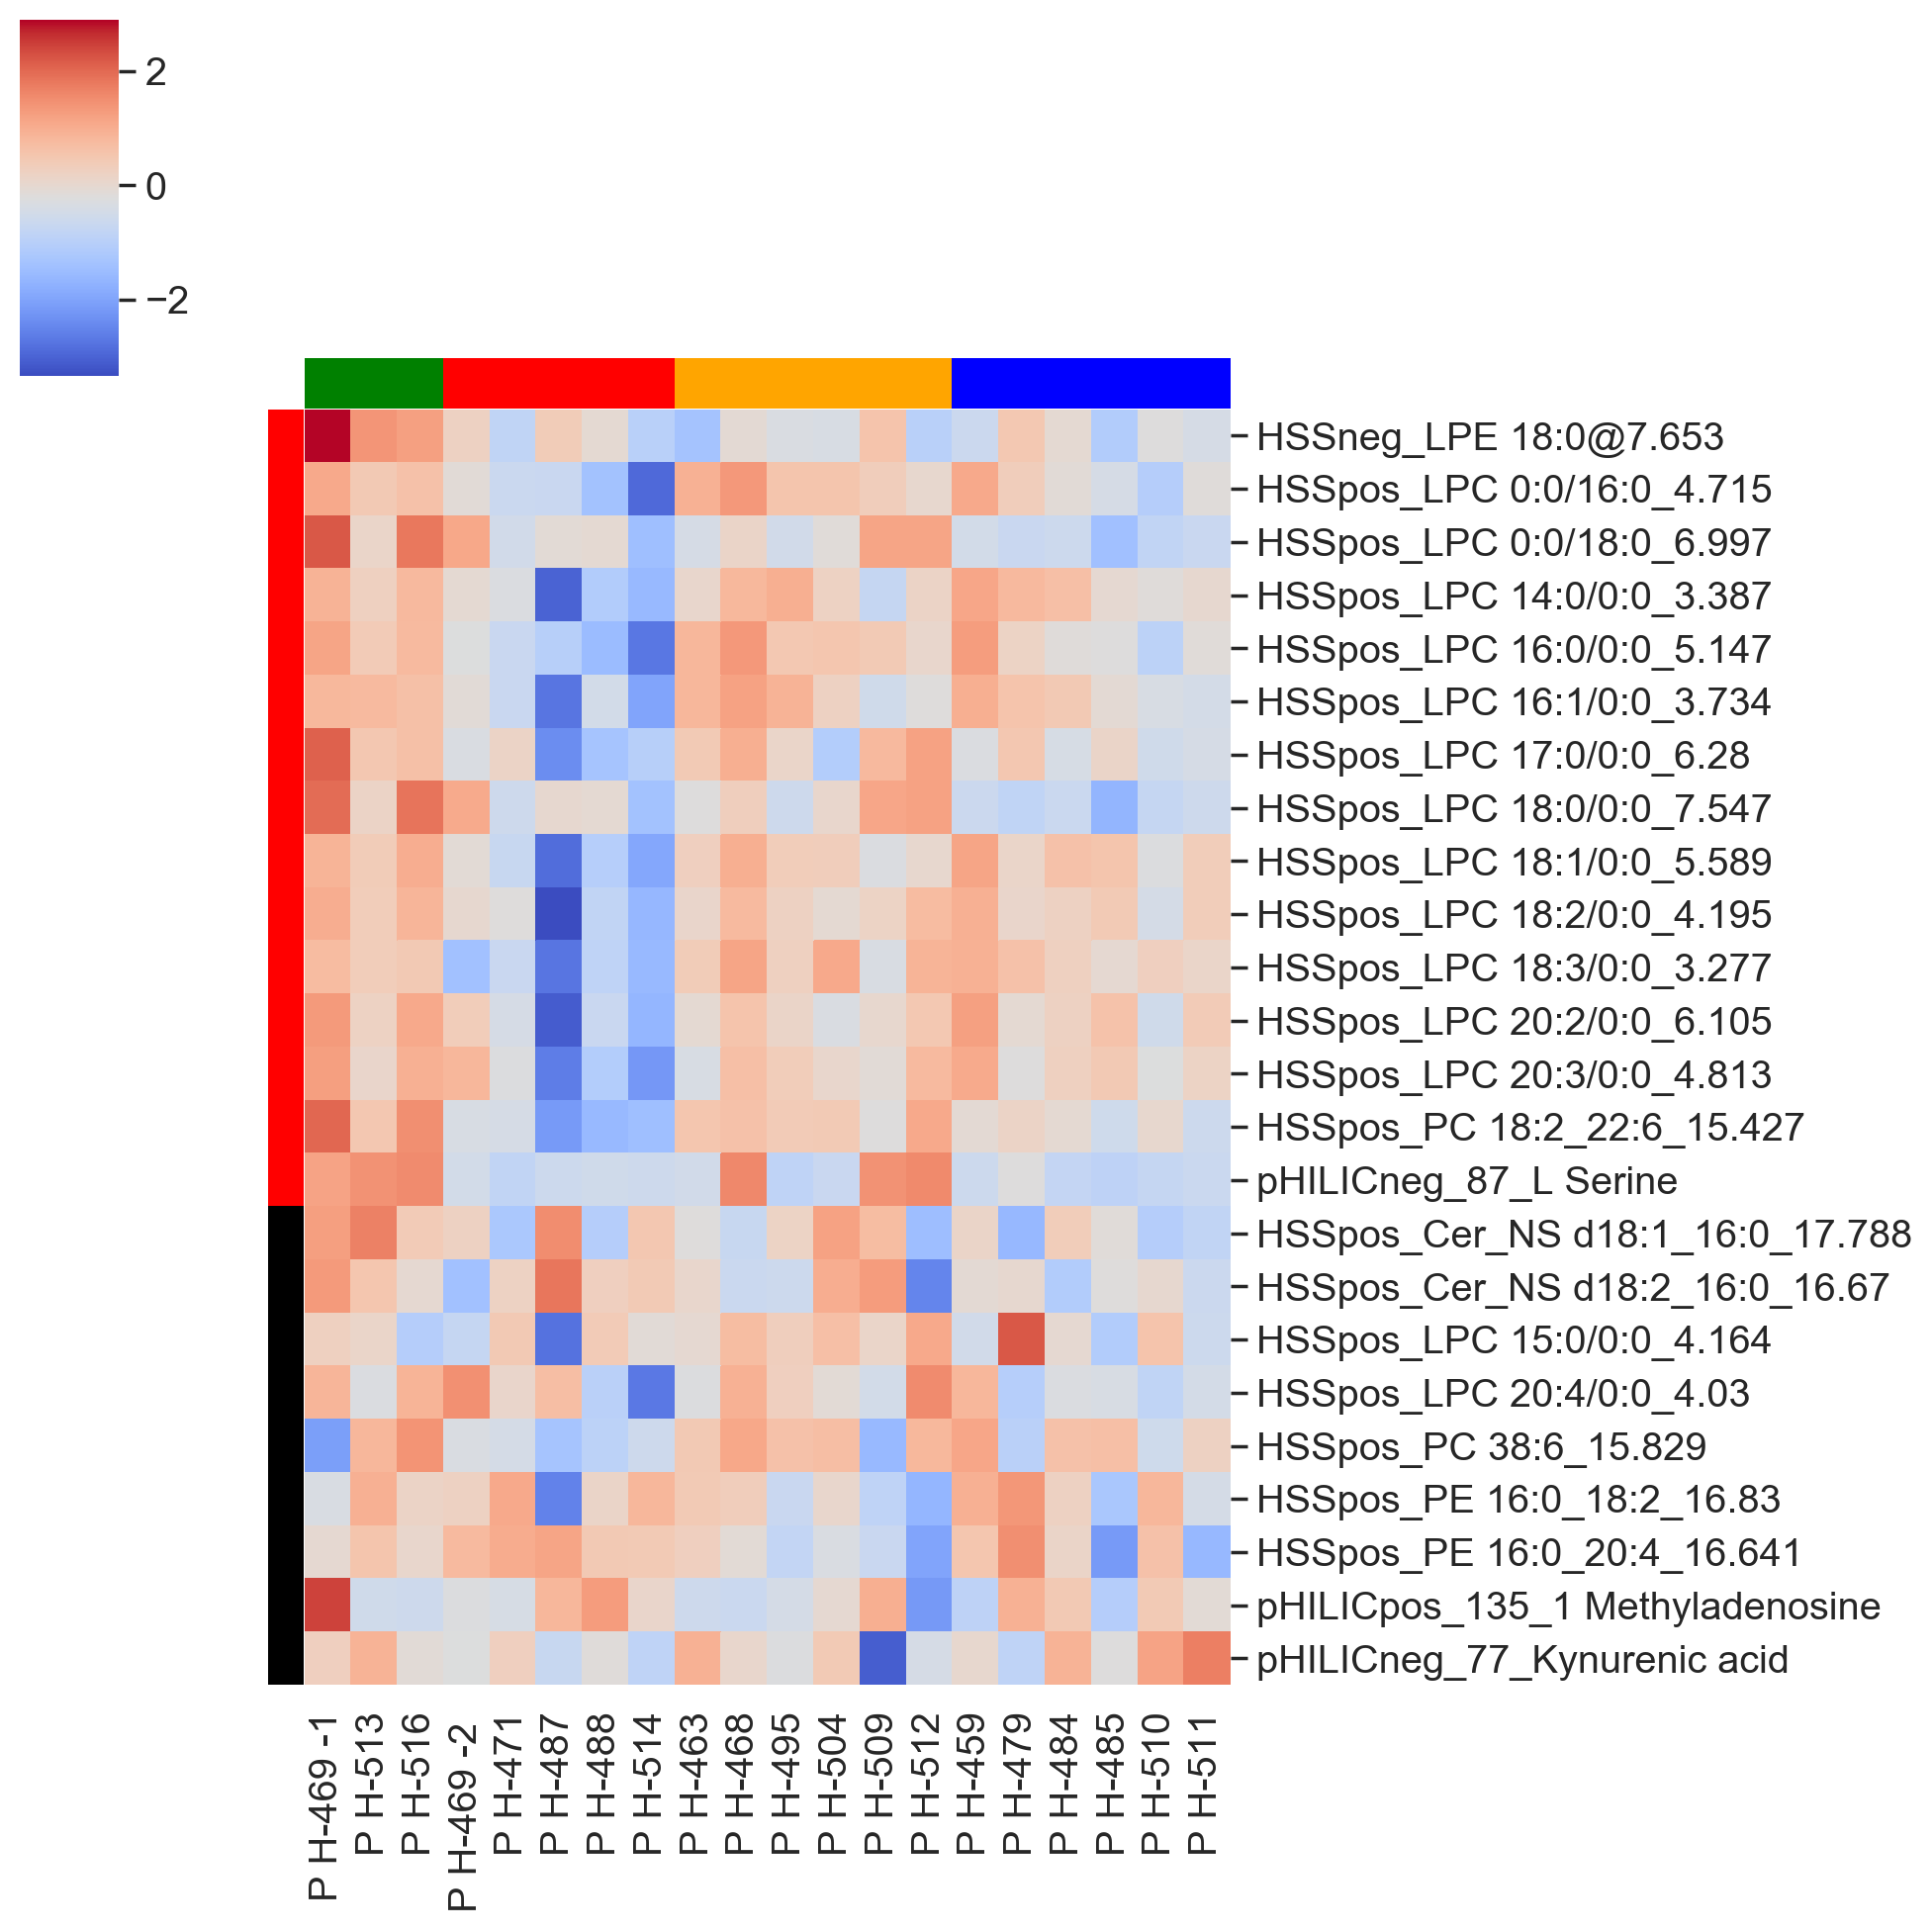

In [86]:
mol_names = data["Compound Name Leg"].values
samples = sample_info.index.values
area_cols = [x for x in data.columns.values if x in samples]
print(len(area_cols),len(samples))
data_matrix = np.log2(data[area_cols].transpose())

var_imp = pd.read_csv("../data/var_importance_final.csv",index_col=0)

vars_of_interest = []
var_names = []
special_case_mapper = {"pHILICpos_196_Kynurenic acid":"pHILICneg_77_Kynurenic acid"}
for x in var_imp.index.values:
    index = 0
    found = False
    if x in special_case_mapper:
        x = special_case_mapper[x]
    for y in mol_names:
        if "@" in y:
            y = y.split("@")[0]
        if y in x:
            vars_of_interest.append(index)
            var_names.append(x)
            found = True
            break
        index += 1
    if not found:
        index = 0
        for y in mol_names:
            if "@" in y:
                y = y.split("@")[0]
            y = y.replace(y.split("_")[0]+"_","")
            if y in x:
                vars_of_interest.append(index)
                var_names.append(x)
                found = True
                break
            index += 1
    if not found:
        print(x)
        
data_matrix = data_matrix.iloc[:,vars_of_interest]
print(data_matrix.shape)
data_matrix.columns = np.array(var_names)

samplesOfInterest = [x for x in data_matrix.index.values if sample_info.at[x,"Group"] in ["SARS-CoV-2"] and sample_info.at[x,"Day post infection"] in [2,4,6,14]]
print(len(samplesOfInterest))
data_matrix = data_matrix.loc[samplesOfInterest,:]

sample_kind_mapping = [sample_info.at[x,"Day post infection"] for x in data_matrix.index.values]

alpha = 0.05
sig_mets = []
pvals = []
plot_dfs = []
total_df = {}
totI=0
for x in range(len(var_names)):
    sub = data_matrix[var_names[x]]

    plot_df = {}
    ind = 0
    for val,kind,samp in zip(sub,sample_kind_mapping,data_matrix.index.values):
        plot_df[ind] = {var_names[x]:val,"Day":kind}
        total_df[totI] = {"intensity":val,"Day":kind,"Metabolite":var_names[x],"sample":samp}
        ind += 1
        totI += 1

    plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
    
    stat,pval = stats.f_oneway(*[plot_df[plot_df["Day"] == d][var_names[x]].values for d in [2,4,6,14]])

#     if pval < alpha/len(mol_names):
#         sig_mets.append(x)
    pvals.append(pval)
        
    plot_dfs.append(plot_df)
colorMapper = {2:"green",4:"red",6:"orange",14:"blue"}
print(len(sig_mets))
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
total_df = pd.DataFrame.from_dict(total_df,orient="index")
sig = {}
for name,p,plot_df in zip(var_names,pvals_corr,plot_dfs):
    if p < alpha:
        plt.figure()
        sb.boxplot(data=plot_df,x="Day",y=name,fliersize=0,palette=colorMapper)
        sb.swarmplot(data=plot_df,x="Day",y=name,palette=colorMapper)
        plt.title(p)
        sig[name] = 1
    else:
        sig[name] = 0
        
plot_df = {}
row_labels = {}
for index,row in total_df.iterrows():
    if row["sample"] not in plot_df:
        plot_df[row["sample"]] = {}
        row_labels[row["sample"]] = row["Day"]
    plot_df[row["sample"]][row["Metabolite"]] = row["intensity"]
plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
row_labels = [row_labels[samp] for samp in plot_df.index.values]
order = [x for x in range(len(plot_df))]
order.sort(key=lambda x: row_labels[x])
row_labels = [row_labels[x] for x in order]
print(row_labels)
sigMapper = {1:"red",0:"black"}
plot_df = plot_df.iloc[order,:].transpose()
col_labels = [sig[x] for x in plot_df.index.values]
order2 = list(range(len(col_labels)))
order2.sort(key=lambda x: col_labels[x],reverse=True)
col_labels = np.array(col_labels)[order2]
plot_df = plot_df.loc[plot_df.index.values[order2],:]
plt.figure()
sb.clustermap(plot_df,z_score=0,row_cluster=False,col_cluster=False,metric="correlation",col_colors=[colorMapper[x] for x in row_labels],row_colors=[sigMapper[x] for x in col_labels],cmap="coolwarm")
